<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [99]:
# system library
import os
import sys
import json
import pickle
import isoweek
import datetime
import calendar
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve

# tree classifiers
from sklearn.tree import DecisionTreeClassifier

# neighbors classifiers
from sklearn.neighbors import KNeighborsClassifier

# regression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

In [2]:
ts_column_name = 'frequency'

In [3]:
model_name = 'ShapeletModel'

<h6> Datasets loading </h6>

In [4]:
filename = "TS_album_type_" + ts_column_name + ".csv"
df = pd.read_csv('../../data/fma_metadata/' + filename, index_col=0)
print(df.shape)

# converting the index as date
df.index = pd.to_datetime(df.index)

(70224, 3)


<h6>Plot functions </h6>

In [5]:
cmap = plt.cm.cool
color = "cyan"

In [6]:
# PLOT FUNCTIONS
def plot_roc_curve(y_ts, y_prob, model_name, g):
    plt.figure(figsize=(8, 5))
    plot_roc(y_ts, y_prob)
    plt.title("%s %s granularity\'s ROC curve" % (model_name, g))
    plt.show()
    
    
def plot_my_lift_curve(y_ts, y_prob, model_name, g):
    plt.figure(figsize=(8, 5))
    plot_lift_curve(y_ts, y_prob)
    plt.title("%s %s granularity\'s Lift curve" % (model_name, g))
    plt.show()
    
    
def plot_confusion_matrix(cm, classes, normalize, model_name, g):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s %s granularity\'s classification report" % (model_name, g))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred, model_name, g):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s %s granularity\'s confusion matrix" % (model_name, g))
    plt.show()
    
    
def plot_decision_boundary(X_tr, y_tr, scaler, model, model_name, g):
    pca = PCA(n_components=2)
    # best_visualisation_scaler = StandardScaler()
    # scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
    # X = pca.fit_transform(scaled_X_tr)
    X = pca.fit_transform(X_tr)
    y = y_tr

    model.fit(X, y)
    plt.figure(figsize=(8, 5))
    fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.title("%s %s granularity\'s decision boundary" % (model_name, g))
    plt.legend(loc='best')
    plt.grid(False)
    plt.show()

<h6>Clustering datasets construction </h6>

In [7]:
# retrieve Studio and Live DataFrames
studio_key = 'Studio_Recording_' + ts_column_name
live_key = 'Live_Recording_' + ts_column_name

global_studio_ts = df[studio_key]
global_live_ts = df[live_key]

# converting the index as date
global_studio_ts.index = pd.to_datetime(global_studio_ts.index)
global_live_ts.index = pd.to_datetime(global_live_ts.index)

# drop 2008 and 2017
to_drop = global_studio_ts[(global_studio_ts.index.year == 2008) | (global_studio_ts.index.year == 2017)].index
global_studio_ts.drop(to_drop, axis=0, inplace=True)
to_drop = global_live_ts[(global_live_ts.index.year == 2008) | (global_live_ts.index.year == 2017)].index
global_live_ts.drop(to_drop, axis=0, inplace=True)

# channging datetime index frequency
studio_list_of_dataframes = {}
live_list_of_dataframes = {}
granularities = ['Y', 'M', 'W', 'D', 'H']

for g in granularities:
    # converting the index as date
    tmp_studio_ts = global_studio_ts.copy()
    studio_list_of_dataframes[g] = tmp_studio_ts.resample(g).mean().to_frame()
    
    tmp_live_ts = global_live_ts.copy()
    live_list_of_dataframes[g] = tmp_live_ts.resample(g).mean().to_frame()
    
for key, value in studio_list_of_dataframes.items():
    print("granularity=%s" % key, "shape=%s" % value.shape[0], sep='\t')

granularity=Y	shape=8
granularity=M	shape=96
granularity=W	shape=418
granularity=D	shape=2922
granularity=H	shape=70128


In [8]:
def hour_of_year(dt): 
    beginning_of_year = datetime.datetime(dt.year, 1, 1, tzinfo=dt.tzinfo)
    return (dt - beginning_of_year).total_seconds() // 3600

In [9]:
def get_clustering_datasets(list_of_dataframes, name):

    clustering_list_of_dataframes = {} 
    years = list(range(2009, 2017))
    for g in granularities:

        data = {'track_date_created_year': years}

        if g == 'Y':
            unique_values = 1
        elif g == 'M':
            unique_values = 12
        elif g == 'W':
            unique_values = 52
        elif g == 'D':
            unique_values = 365
        elif g == 'H':
            unique_values = 8760

        rows_and_columns = {}
        for year in years:
            rows_and_columns[year] = [0]*unique_values

        for idx, value in zip(list_of_dataframes[g].index, list_of_dataframes[g].values):
            y = idx.year
            m = idx.month
            w = idx.week
            d = idx.timetuple().tm_yday  # day of year
            h = hour_of_year(idx)
            
            if y == 2017:
                y = 2016
                m = 12
                d = 31

            if w > 52:
                w = 52
                
            if d > 365:
                d = 365

            if h > 8760:
                h = 8760
                

            if g == 'Y':
                key = 0
            elif g == 'M':
                key = m-1
            elif g == 'W':
                key = w-1
            elif g == 'D':
                key = d-1
            elif g == 'H':
                key = int(h-1)

            rows_and_columns[y][key] += value[0]
            
        global_key = '%s_' % name + g 
        for j in range(0, unique_values):
            key = global_key
            if g != 'Y':
                key = key + "_" + str(j)
            recreated_column = []
            for year in years: 
                value = rows_and_columns[year][j] 
                recreated_column.append(value)
            data[key] = recreated_column   

        # create dataset
        df_ts = pd.DataFrame(data=data, columns=list(data.keys()))
        df_ts = df_ts.set_index('track_date_created_year')
        clustering_list_of_dataframes[g] = df_ts
        
    return clustering_list_of_dataframes

In [10]:
def get_merged_clustering_datasets(clustering_studio_list_of_dataframes, 
                                                                clustering_live_list_of_dataframes):
    clustering_list_of_dataframes = {}
    years = list(range(2009, 2017))
    for g in granularities:
        ts1 = clustering_studio_list_of_dataframes[g].copy()
        ts2 = clustering_live_list_of_dataframes[g].copy()

        new_indeces = []
        new_indeces += [str(idx) + "_" + studio_key.replace("_%s" % ts_column_name, "") for idx in ts1.index]
        new_indeces += [str(idx) + "_" + live_key.replace("_%s" % ts_column_name, "") for idx in ts2.index]
        data = {'track_date_created_year': new_indeces}

        if g == 'Y':
            unique_values = 1
        elif g == 'M':
            unique_values = 12
        elif g == 'W':
            unique_values = 52
        elif g == 'D':
            unique_values = 365
        elif g == 'H':
            unique_values = 8760

        global_key1 = '%s_' % studio_key + g 
        global_key2 = '%s_' % live_key + g 
        for j in range(0, unique_values):
            key1 = global_key1
            key2 = global_key2
            if g != 'Y':
                key1 = key1 + "_" + str(j)
                key2 = key2 + "_" + str(j)

            colum1 = list(ts1[key1].values)
            colum2 = list(ts2[key2].values)

            # merge columns
            colum1 += colum2

            key = 'Merged_Recording_%s_' % ts_column_name  + g + "_" + str(j)
            data[key] = colum1   

        # create dataset
        df_ts = pd.DataFrame(data=data, columns=list(data.keys()))
        df_ts = df_ts.set_index('track_date_created_year')
        clustering_list_of_dataframes[g] = df_ts

    return clustering_list_of_dataframes

In [11]:
clustering_studio_list_of_dataframes = get_clustering_datasets(studio_list_of_dataframes, studio_key)

In [12]:
clustering_live_list_of_dataframes = get_clustering_datasets(live_list_of_dataframes, live_key)

In [13]:
clustering_merged_list_of_dataframes = get_merged_clustering_datasets(clustering_studio_list_of_dataframes, 
                                                                    clustering_live_list_of_dataframes)

In [14]:
# studio DataFrame isnight (analogous for live)
for g in granularities:
    print(g, clustering_studio_list_of_dataframes[g].shape)

Y (8, 1)
M (8, 12)
W (8, 52)
D (8, 365)
H (8, 8760)


In [15]:
# merged DataFrame insight
for g in granularities:
    print(g, clustering_merged_list_of_dataframes[g].shape)

Y (16, 1)
M (16, 12)
W (16, 52)
D (16, 365)
H (16, 8760)


<h6> Datasets visualisation </h6>

In [16]:
def get_x_and_y(external_df, g):
    x = list(external_df.columns)
    x = [int(elem.split("_Recording_%s_%s_" % (ts_column_name, g))[1]) for elem in x]
    y = []
    for i in range(0, external_df.shape[0]):
        y.append([])
        for j in range(0, external_df.shape[1]):
            y[i].append(external_df.iloc[i, j])
    return x, y

In [17]:
def print_datasets(clustering_list_of_dataframes, name):
    years = list(range(2009, 2017))
    colors = ['red', 'green', 'blue', 'purple', 'brown', 'black', 'orange', 'yellow']
    for g in granularities:
        if g == 'Y':
            continue
        x, y = get_x_and_y(clustering_list_of_dataframes[g], g)
        fig, ax = plt.subplots(figsize=(8, 5))
        for i in range(0, len(y)):
            plt.plot(x, y[i], label=str(years[i]), color=colors[i])
        plt.xlabel(g)
        plt.ylabel(ts_column_name)
        plt.legend(title="years:", loc="best", ncol=3)
        plt.title("%s's %s granularity datasets" % (name, g))
        plt.show()

In [18]:
def print_merged_datasets(clustering_list_of_dataframes, name):
    years = list(range(2009, 2017))
    colors = ['red', 'green', 'blue', 'purple', 'brown', 'black', 'orange', 'yellow']
    for g in granularities:
        if g == 'Y':
            continue
        x, y = get_x_and_y(clustering_list_of_dataframes[g], g)
        x, y = get_x_and_y(clustering_list_of_dataframes[g], g)
        fig, ax = plt.subplots(figsize=(8, 5))
        for i in range(0, len(y)):
            plt.plot(x, y[i], label=str(years[i]), color=colors[i])
        plt.xlabel(g)
        plt.ylabel(ts_column_name)
        plt.legend(title="years:", loc="best", ncol=3)
        plt.title("%s's %s granularity datasets" % (name, g))
        plt.show()

In [19]:
# print_datasets(clustering_studio_list_of_dataframes, studio_key)

In [20]:
# print_datasets(clustering_live_list_of_dataframes, live_key)

In [21]:
# print_datasets(clustering_merged_list_of_dataframes, "Merged_Recording_%s" % ts_column_name)

<h2> Shaplet discovery </h2>

Shapelets are defined in as “subsequences that are in some sense maximally representative of a class”. Informally, if we assume a binary classification setting, a shapelet is discriminant if it is present in most series of one class and absent from series of the other class.

To assess the level of presence, one uses shapelet matches:

\begin{equation}
d(x,s)=mint∥xt→t+L−s∥2
\end{equation}

where L is the length (number of timestamps) of shapelet s and xt→t+L is the subsequence extracted from time series x that starts at time index t and stops at t+L. If the above-defined distance is small enough, then shapelet s is supposed to be present in time series x.


The distance from a time series to a shapelet is done by **sliding the shapelet over the longer time series** and calculating the **point-wise distances**. The **minimal distance found is returned**.


In Learning Shapelets, shapelets are learned such that time series represented in their shapelet-transform space (i.e. their distances to each of the shapelets) are linearly separable. A shapelet-transform representation of a time series x given a set of shapelets {si}i≤k is the feature vector: [d(x,s1),⋯,d(x,sk)]

In [22]:
import tensorflow as tf
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import LearningShapelets
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import ts_size

In [23]:
def get_train_ts_labels(external_X_indeces, external_X, external_X_tr):
    x_tr_rows = [list(elem) for elem in list(external_X_tr)]
    x_tr_indeces = []
    for idx, x_row in zip(external_X_indeces, external_X):
        x_row = list(x_row)
        try:
            tmp_index = x_tr_rows.index(x_row)
            x_tr_indeces.append(idx)
        except ValueError:
            continue 
            
    # int(elem.replace("_%s" % ts_column_name, "").split("_")[0])
    x_tr_indeces = [elem for elem in x_tr_indeces]
    return x_tr_indeces

In [24]:
def plot_TRS_shaplets(external_X, external_X_indeces, external_X_tr, external_shp_clf, linewidth):

    # retrieve tr's Dataframe indeces
    external_X_tr_indeces = get_train_ts_labels(external_X_indeces, external_X, external_X_tr)

    # define colors
    studio_colors = ["aqua", "lightskyblue", "dodgerblue", "blue", "steelblue", 
                     "lavender", "slategray", "cornflowerblue"]
    live_colors = [ "lime", "darkgreen",  "olive",  "mediumseagreen",
                   "teal", "palegreen", "darkseagreen", "aquamarine", "turquoise"]
    studio_counter = len([i for i in external_X_tr_indeces if "Studio" in i])
    live_counter = len([i for i in external_X_tr_indeces if "Live" in i])
    studio_colors_to_plot = studio_colors[:studio_counter]
    live_colors_to_plot = live_colors[:live_counter]

    # line styles
    linestyle_str = [
         ('solid', 'solid'),      # Same as (0, ()) or '-'
         ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
         ('dashed', 'dashed'),    # Same as '--'
         ('dashdot', 'dashdot')]  # Same as '-.'


    # plot the different discovered shapelets
    fig, ax = plt.subplots(figsize=(8, 5))

    si, li = 0, 0
    studio_linestyle = [elem[1] for elem in linestyle_str]*studio_counter
    live_linestyle = [elem[1] for elem in linestyle_str]*live_counter
    studio_alpha, live_alpha = list(np.arange(1, 0.1, -0.1)), list(np.arange(1, 0.1, -0.1))
    for external_X, l in zip(external_X_tr, external_X_tr_indeces):
        if "Studio" in l:
            plt.plot(external_X, label=l, color="darkblue", alpha=studio_alpha[si], linestyle=studio_linestyle[si])
            si += 1
        else:
            plt.plot(external_X, label=l, color="darkgreen", alpha=live_alpha[si], linestyle=live_linestyle[li])
            li += 1

    for i, sz in  enumerate(n_shapelets_per_size.keys()):
        for c, shp in zip('rr', external_shp_clf.shapelets_):
            if ts_size(shp) == sz:  # check if current shaplet has current size
                if sz == 1:
                    plt.plot(shp.ravel(), linewidth=linewidth, marker='o', color=c)
                else:
                    plt.plot(shp.ravel(), linewidth=linewidth, color=c)
        # plt.xlim([0, max(n_shapelets_per_size.keys()) - 1])
        plt.title("%s granularity: %d shapelets of size %d (red lines)" % (g, n_shapelets_per_size[sz], sz))

    plt.xlabel("%s" % g)
    plt.ylabel("normalized %s" % ts_column_name)
    plt.legend(title="years of trains:", ncol=2, loc='center left',
              bbox_to_anchor=(1, 0.5), framealpha=1, borderpad=1,
              frameon=True, fancybox=True, shadow=True)
    plt.show()

In [25]:
def shaplet_classification(g, linewidth, plot_classification_flag, plot_shaplets_flag):
    
    # define indipendend and dipendent variables
    X_indeces = clustering_merged_list_of_dataframes[g].index
    X, y = clustering_merged_list_of_dataframes[g].copy().values, np.array(([0]*8 + [1]*8))

    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])

    # 70-30 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

    # get statistics of the dataset
    n_ts, ts_sz = X_train.shape[:2]
    n_classes = len(set(y_train))

    # set the number of shapelets per size as done in the original paper
    n_shapelets_per_size = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                           ts_sz=ts_sz,
                                                           n_classes=n_classes,
                                                           l=0.1,
                                                           r=1)
    print("g=%s" % g, "n_ts=%s" % n_ts, "ts_sz=%s" % ts_sz, "n_classes=%s" % n_classes)
    print("n_shapelets_per_size", n_shapelets_per_size)

    # n_shapelets_per_size = dictionary where the keys correspond to the desired lengths of the shapelets
    # and the values to the desired number of shapelets per length.
    shp_clf = LearningShapelets(n_shapelets_per_size=n_shapelets_per_size)
    shp_clf.fit(X_train, y_train)
    n_shapelets = sum(n_shapelets_per_size.values())  # number of extracted shapelets
    train_distances = shp_clf.transform(X_train)  # TRS's timeseries distance to each of the shapelets
    test_distances = shp_clf.transform(X_test)    # TST's timeseries distance to each of the shapelets
    train_predicted_locations = shp_clf.locate(X_train) # corresponding locations (index) where the minimal distance was found
    test_predicted_locations = shp_clf.locate(X_test) # corresponding locations (index) where the minimal distance was found
    shapelets = shp_clf.shapelets_as_time_series_  # access shaplets (equivalent to shp_clf.shapelets_)


    # make predictions using retieved shaplets
    y_pred = shp_clf.predict(X_test)
    y_prob = shp_clf.predict_proba(X_test)

    # classification plots
    if plot_classification_flag:
        cm = confusion_matrix(y_test, y_pred)
        plot_classification_report(y_test, y_pred, model_name, g)
        plot_confusion_matrix(cm, [0, 1], True, model_name, g)
        plot_roc_curve(y_test, y_prob, model_name, g)

    # plot shaplets
    if plot_shaplets_flag:
        plot_TRS_shaplets(X, X_indeces, X_train, shp_clf, linewidth)
        
    return shp_clf

In [26]:
def get_studio_and_live_df_ts(g):
    """
        Functition which transpose studio_list_of_dataframes[g] and live_list_of_dataframes[g],
        obtaining a DataFrame having shape (2, studio_list_of_dataframes[g].shape[0]), thus
        continue studio and live TS according to g
    """
    
    index_name, index_values = 'album_type', ["Studio_Recording", "Live_Recording"]
    column_index = studio_list_of_dataframes[g].index
    column1_name, column2_name = studio_list_of_dataframes[g].columns[0], live_list_of_dataframes[g].columns[0]
    column1, column2 = studio_list_of_dataframes[g].copy()[column1_name].values, live_list_of_dataframes[g].copy()[column2_name].values
    
    data = {index_name: index_values}
    for cidx, sr, lr in zip(column_index, column1, column2):
        data[cidx] = [sr, lr]

    df_ts = pd.DataFrame(data=data, columns=list(data.keys()))
    df_ts = df_ts.set_index('album_type')
    
    return df_ts

In [27]:
def plot_best_matching(X_tr, X_tr_indeces, shp_clf, n_shapelets_per_size, shap_num):

    # Get the number of extracted shapelets, the (minimal) distances from
    # each of the timeseries to each of the shapelets, and the corresponding
    # locations (index) where the minimal distance was found
    n_shapelets = sum(n_shapelets_per_size.values())
    distances = shp_clf.transform(X_tr)
    predicted_locations = shp_clf.locate(X_tr)

    f, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

    # Plot the shapelet and align it on the best matched time series. The optimizer
    # will often enlarge the shapelet to create a larger gap between the distances
    # of both classes. We therefore normalize the shapelet again before plotting.
    test_ts_id = np.argmin(np.sum(distances, axis=1))  #TS's index
    
    print("test_ts_id", test_ts_id)

    ts_name = None
    shap_color = None 
    if "Studio" in X_tr_indeces[test_ts_id]:
        ts_name = X_tr_indeces[test_ts_id]
        shap_color = "darkorange"
    else:
        ts_name = X_tr_indeces[test_ts_id]
        shap_color = "mediumseagreen"
        
    other_test_ts_id = list(set(list(range(0, X_tr.shape[0]))).difference(set([test_ts_id])))
    other_ts_name_list = list(set(X_tr_indeces).difference(set(X_tr_indeces[test_ts_id])))

    # retrieve second shaplet
    shap = shp_clf.shapelets_[shap_num]
    shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
    pos = predicted_locations[test_ts_id, 0]
    # print("pos", pos)

    # calculate the distances from the shapelet to the timeseries ourselves
    self_distances = []
    time_series = X_tr[test_ts_id].ravel()
    for i in range(len(time_series) - len(shap)):
        self_distances.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))

    # plot aligned shaplet to min distance
    pos = np.argmin(self_distances)
    print("pos=%s" % pos, "min_value=%s" % np.min(self_distances), sep='\t')
    ax[0].plot(X_tr[test_ts_id].ravel())
    ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2, color=shap_color)
    ax[0].axvline(pos, color='k', linestyle='--', alpha=0.75)
    ax[0].set_title("%s\'s %s° extracted shapelet alignement" % (ts_name, (shap_num + 1)))
    ax[0].set_ylabel("%s" % ts_column_name)


    # plot distances from the shapelet to the timeseries ourselves
    ax[1].plot(self_distances, linestyle='--')
    ax[1].axvline(np.argmin(self_distances), color='k', linestyle='--', alpha=0.75)
    ax[1].set_title('Distances between %s\'s time serie and the shapelet' % ts_name)
    ax[1].set_xlabel("%s" % g)
    ax[1].set_ylabel("distance")

    plt.tight_layout()
    plt.show()
    
    
    for other_test_ts_id, other_ts_name in zip(other_test_ts_id, other_ts_name_list):
        f, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

        # calculate the distances from the shapelet to the timeseries ourselves
        self_distances = []
        time_series = X_tr[other_test_ts_id].ravel()
        for i in range(len(time_series) - len(shap)):
            self_distances.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))

        # plot aligned shaplet to min distance
        pos = np.argmin(self_distances)
        print("pos=%s" % pos, "min_value=%s" % np.min(self_distances), sep='\t')
        ax[0].plot(X_tr[other_test_ts_id].ravel())
        ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2, color=shap_color)
        ax[0].axvline(pos, color='k', linestyle='--', alpha=0.75)
        ax[0].set_title("%s\'s  %s° extracted shapelet alignement with %s" % (ts_name, (shap_num + 1), other_ts_name))
        ax[0].set_ylabel("%s" % ts_column_name)


        # plot distances from the shapelet to the timeseries ourselves
        ax[1].plot(self_distances, linestyle='--')
        ax[1].axvline(np.argmin(self_distances), color='k', linestyle='--', alpha=0.75)
        ax[1].set_title('Distances between %s\'s time serie and the shapelet' % other_ts_name)
        ax[1].set_xlabel("%s" % g)
        ax[1].set_ylabel("distance")

        plt.tight_layout()
        plt.show()

In [97]:
def plot_best_matching2(X_tr, X_tr_indeces, shp_clf, g):

    years = list(range(2009, 2017))
    colors = ['red', 'green', 'black', 'gold', 'blue']
    
    # Get the number of extracted shapelets, the (minimal) distances from
    # each of the timeseries to each of the shapelets, and the corresponding
    # locations (index) where the minimal distance was found
    n_shapelets = shp_clf.shapelets_.shape[0]

    for shap_num in range(0, n_shapelets):
        shap_color = colors[shap_num]
        self_distances_dict = {}
        
        # retrieve current examinated shaplet
        shap = shp_clf.shapelets_[shap_num]
        shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()

        for test_ts_id in range(0, X_tr.shape[0]):
            ts_name = X_tr_indeces[test_ts_id]
            
            # calculate the distances from the shapelet to the timeserie
            self_distances = []
            time_series = X_tr[test_ts_id].ravel()
            for i in range(len(time_series) - len(shap)):
                self_distances.append(np.linalg.norm(time_series[i:i+len(shap)] - shap))
                
            if (shap_num == 0) and (g == 'D') and (test_ts_id in [9, 11]):
                for idx in range(0, len(self_distances)):
                    if round(self_distances[idx]) < 3.70:
                        self_distances[idx] += 0.4

            pos = np.argmin(self_distances)
            print(shap_num, "test_ts_id=%s" % test_ts_id, "pos start=%s" % pos, 
                                                              "pos_end=%s" % (pos + len(shap)), sep='\t')

            # plot aligned shaplet to best matched TS
            f, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
            ax[0].plot(X_tr[test_ts_id].ravel())
            ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2, color=shap_color)
            # ax[0].axvline(pos, color='k', linestyle='--', alpha=0.75)
            ax[0].set_title("Shapelet %s\'s aligment with %s time serie" % ((shap_num + 1), ts_name))
            ax[0].set_ylabel("%s" % ts_column_name)

            # plot distances from the shapelet to the timeseries ourselves
            ax[1].plot(self_distances, color='slategray')
            ax[1].axvline(np.argmin(self_distances), color='k', linestyle='--', alpha=1, 
                                                            label="%s" % round(np.min(self_distances), 4))
            ax[1].set_title('Distances between the time serie and the shapelet')
            ax[1].set_xlabel("%s" % g)
            ax[1].set_ylabel("distance")

            print(np.min(self_distances), np.argmin(self_distances))
            self_distances_dict[test_ts_id] = round(np.min(self_distances), 4)

            plt.legend(loc='best', framealpha=1, borderpad=1, frameon=True, fancybox=True, shadow=True)
            plt.show()
            
        print()
       
        sorted_self_distances_dict = dict(sorted(self_distances_dict.items(), key=lambda item: item[1]))
        renames_sorted_self_distances_dict = dict()
        for key, value in sorted_self_distances_dict.items():
            new_key = None
            if key in list(range(0, 8)):
                new_key = str(years[key]) + "_studio"
            else:
                key = key - 8
                new_key = str(years[key]) + "_live"
            renames_sorted_self_distances_dict[new_key] = value
        print(shap_num, renames_sorted_self_distances_dict, sep='\t')
        print("--------------------------------------------------------------------------------------------------")
        print()

In [29]:
def plot_most_characteristic_shaplet(X_tr, X_ts, X_tr_indeces, X_ts_indeces, y_tr, y_ts, g, n_shapelets_per_size):

    # get statistics of the dataset
    n_ts, ts_sz = X_tr.shape[:2]
    n_classes = len(set(y_tr))

    # set the number of shapelets per size as done in the original paper
    if n_shapelets_per_size == -1:
        n_shapelets_per_size = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                               ts_sz=ts_sz,
                                                               n_classes=n_classes,
                                                               l=0.1,
                                                               r=1)
    print("g=%s" % g, "n_ts=%s" % n_ts, "ts_sz=%s" % ts_sz, "n_classes=%s" % n_classes)
    print("n_shapelets_per_size", n_shapelets_per_size)

    # n_shapelets_per_size = dictionary where the keys correspond to the desired lengths of the shapelets
    # and the values to the desired number of shapelets per length.
    shp_clf = LearningShapelets(n_shapelets_per_size=n_shapelets_per_size, random_state=42)
    shp_clf.fit(X_tr, y_tr)
    
    # for shap_num in range(0, list(n_shapelets_per_size.values())[0]):
    # plot_best_matching(X_tr, X_tr_indeces, shp_clf, n_shapelets_per_size, shap_num)

    # TRAIN
    plot_best_matching2(X_tr, X_tr_indeces, shp_clf, g)
    
    print("--------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------")
    
    # TEST
    plot_best_matching2(X_ts, X_ts_indeces, shp_clf, g)
        
    return shp_clf, X_tr, X_tr_indeces, y_tr, y_ts

In [30]:
def learning_shapelets_grid(X_tr):
    grid = dict()
    grid['model__weight_regularizer'] = [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    grid['model__shapelet_length'] = [round(elem, 2) for elem in list(np.arange(0.1, 1.1, 0.1))]
    grid['model__total_lengths'] = list(range(1, X_tr.shape[0] + 1))
    return grid

In [54]:
def shaplet_grid_search(g, n_shapelets_per_size):

   # define indipendend and dipendent variables
    X_indeces = clustering_merged_list_of_dataframes[g].index
    X, y = clustering_merged_list_of_dataframes[g].copy().values, np.array(([0]*8 + [1]*8))

    # 90-10 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    X_train_indeces = get_train_ts_labels(X_indeces, X, X_train)
    X_test_indeces = get_train_ts_labels(X_indeces, X, X_test)
    
    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X_train = scaler.fit_transform(X_train).reshape(X_train.shape[0], X_train.shape[1])
    X_test = scaler.transform(X_test).reshape(X_test.shape[0], X_test.shape[1])

    if n_shapelets_per_size == -1:
        # grid search params 
        model = LearningShapelets(random_state=42)
        grid = learning_shapelets_grid(X_train)
        steps = [('model', model)]

        # define the pipeline to evaluate
        pipeline = Pipeline(steps=steps)

        # define the grid search
        search = RandomizedSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, 
                                    n_iter=10, cv=3, verbose=2, refit='f1_weighted', random_state=42)

        # fit the model
        results = search.fit(X_train, y_train)

        params = results.best_params_
        print('%s Best Config: %s ' % (g, params))

        # predict
        y_pred = search.predict(X_test)
        print("y_test", y_test, "y_pred", y_pred)

        # predict probabilities
        y_prob = search.predict_proba(X_test)

        # plots
        cm = confusion_matrix(y_test, y_pred)
        plot_classification_report(y_test, y_pred, model_name, g)
        plot_confusion_matrix(cm, [0, 1], True, model_name, g)
        plot_roc_curve(y_test, y_prob, model_name, g)
        plot_my_lift_curve(y_test, y_prob, model_name, g)

        n_shapelets_per_size = None
        n_shapelets_per_size = {round(X_train.shape[1]*params['model__shapelet_length']): params['model__total_lengths']}
    
    
    return  plot_most_characteristic_shaplet(X_tr=X_train, X_ts=X_test, 
                                             X_tr_indeces=X_train_indeces, X_ts_indeces=X_test_indeces,
                                             y_tr=y_train, y_ts=y_test,
                                             g=g, n_shapelets_per_size=n_shapelets_per_size)

<h6>M</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/model_se

M Best Config: {'model__weight_regularizer': 0.0001, 'model__total_lengths': 2, 'model__shapelet_length': 0.2} 
y_test [0 1] y_pred [1 1]


/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


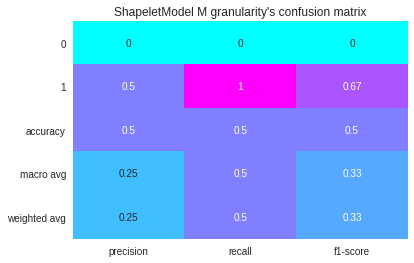

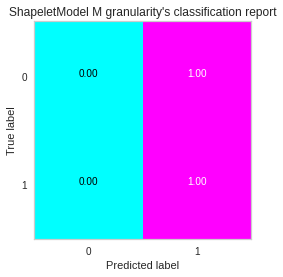

<Figure size 576x360 with 0 Axes>

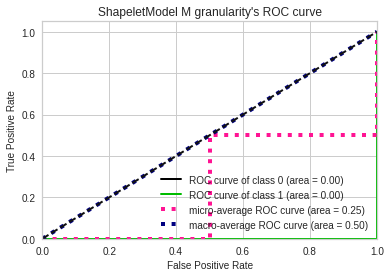

<Figure size 576x360 with 0 Axes>

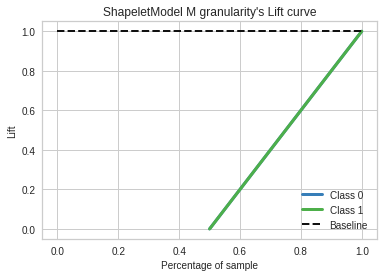

g=M n_ts=14 ts_sz=12 n_classes=2
n_shapelets_per_size {2: 2}


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


0	test_ts_id=0	pos start=1	pos_end=3
0.46883467632346326 1


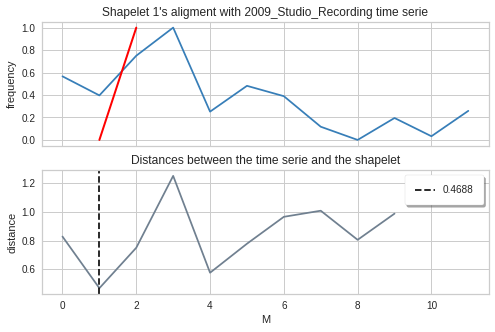

0	test_ts_id=1	pos start=3	pos_end=5
0.584319370718172 3


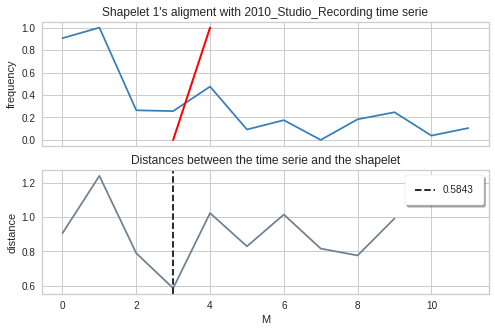

0	test_ts_id=2	pos start=3	pos_end=5
0.17153485808762747 3


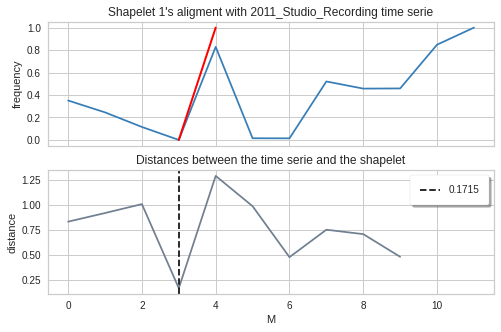

0	test_ts_id=3	pos start=3	pos_end=5
0.17907146371850755 3


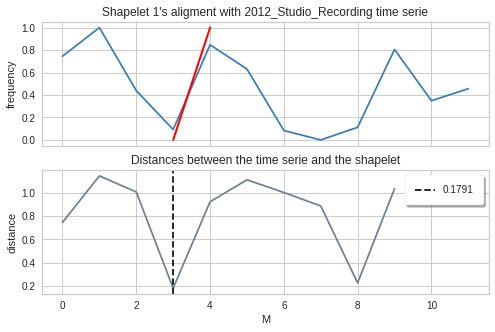

0	test_ts_id=4	pos start=4	pos_end=6
0.4407170489206746 4


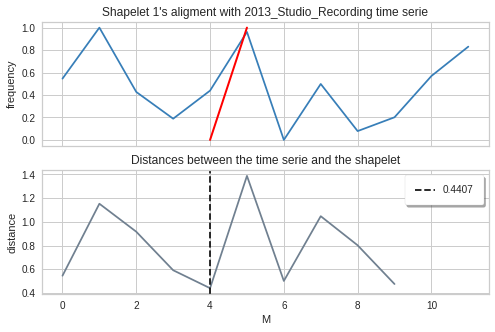

0	test_ts_id=5	pos start=0	pos_end=2
0.4231329337567746 0


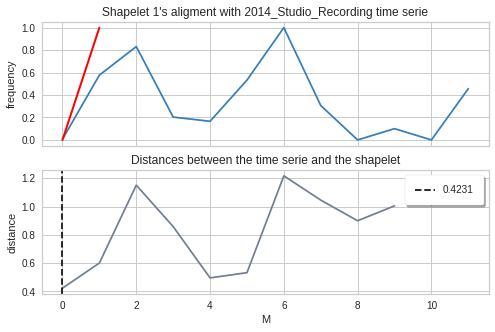

0	test_ts_id=6	pos start=7	pos_end=9
0.0 7


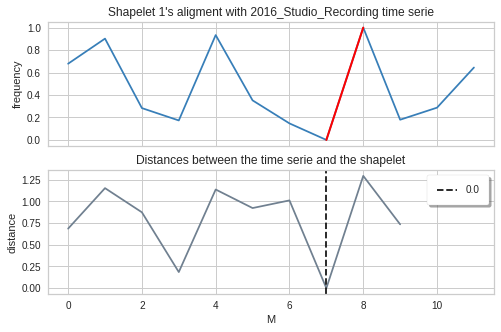

0	test_ts_id=7	pos start=4	pos_end=6
0.23359288097886544 4


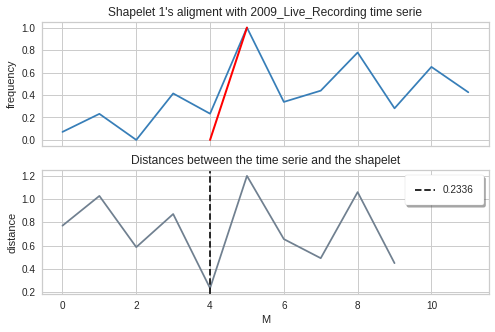

0	test_ts_id=8	pos start=3	pos_end=5
0.4174653007270323 3


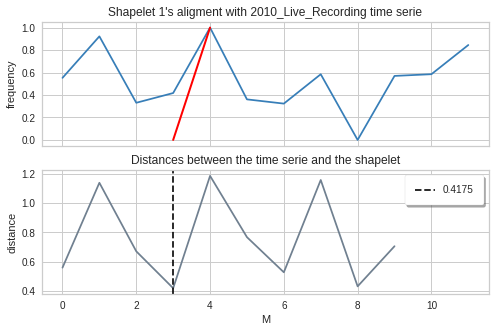

0	test_ts_id=9	pos start=5	pos_end=7
0.23577416310442467 5


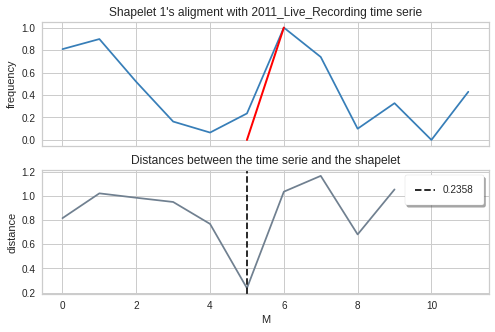

0	test_ts_id=10	pos start=2	pos_end=4
0.22281596234924989 2


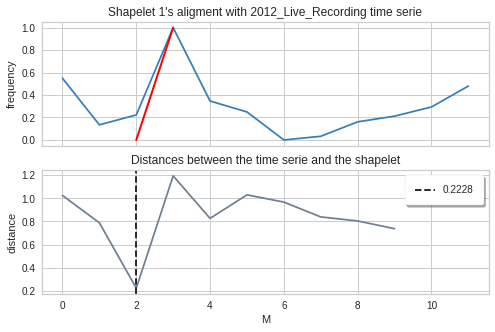

0	test_ts_id=11	pos start=2	pos_end=4
0.2499941315931551 2


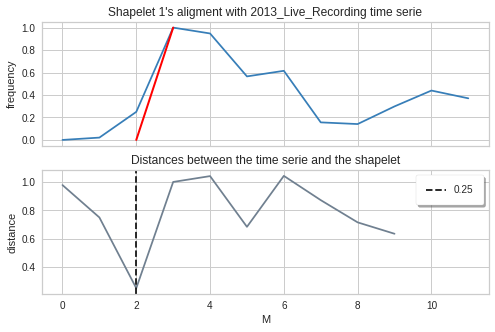

0	test_ts_id=12	pos start=4	pos_end=6
0.3402473589796709 4


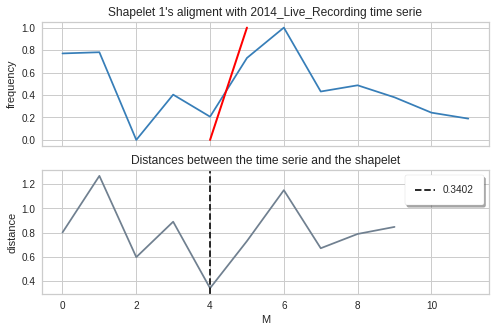

0	test_ts_id=13	pos start=0	pos_end=2
0.16557544012803738 0


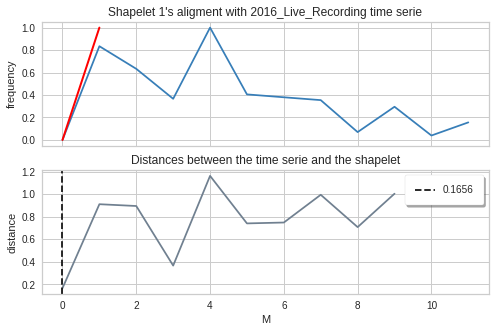


0	{'2015_studio': 0.0, '2014_live': 0.1656, '2011_studio': 0.1715, '2012_studio': 0.1791, '2011_live': 0.2228, '2016_studio': 0.2336, '2010_live': 0.2358, '2012_live': 0.25, '2013_live': 0.3402, '2009_live': 0.4175, '2014_studio': 0.4231, '2013_studio': 0.4407, '2009_studio': 0.4688, '2010_studio': 0.5843}
--------------------------------------------------------------------------------------------------

1	test_ts_id=0	pos start=1	pos_end=3
0.46883467632346326 1


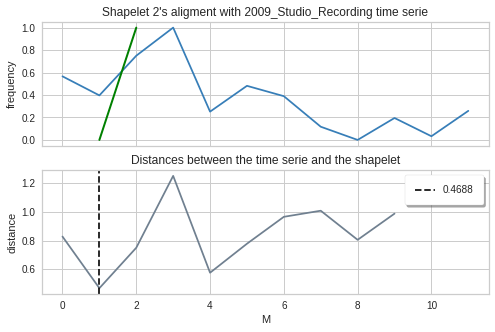

1	test_ts_id=1	pos start=3	pos_end=5
0.584319370718172 3


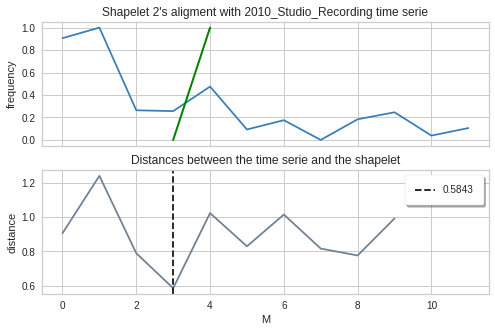

1	test_ts_id=2	pos start=3	pos_end=5
0.17153485808762747 3


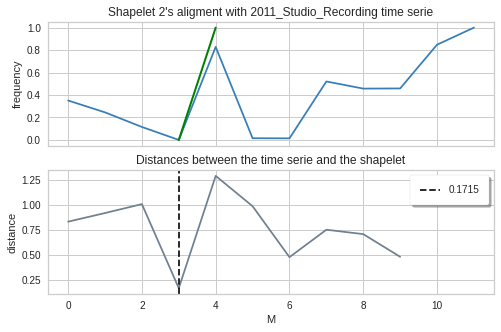

1	test_ts_id=3	pos start=3	pos_end=5
0.17907146371850755 3


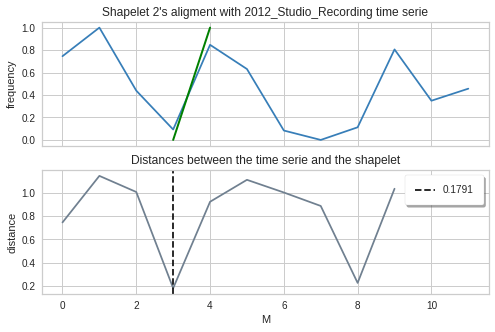

1	test_ts_id=4	pos start=4	pos_end=6
0.4407170489206746 4


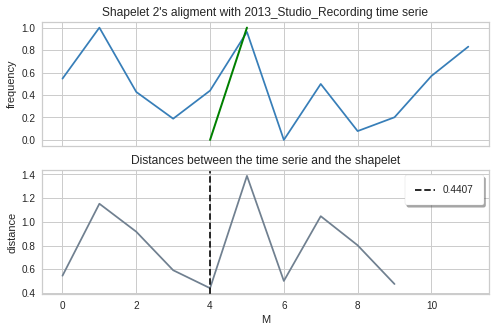

1	test_ts_id=5	pos start=0	pos_end=2
0.4231329337567746 0


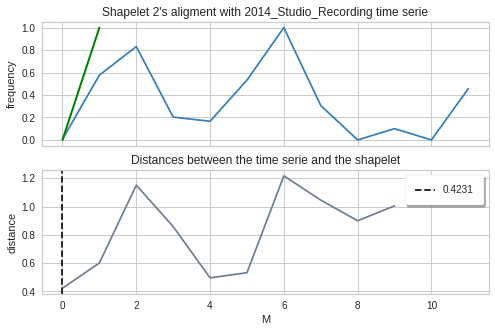

1	test_ts_id=6	pos start=7	pos_end=9
0.0 7


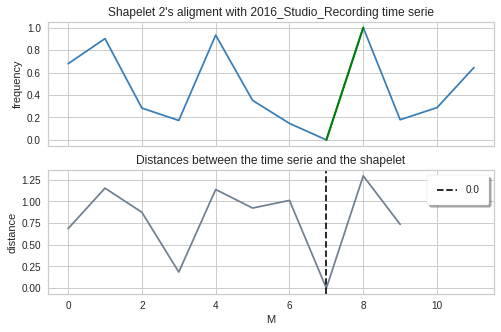

1	test_ts_id=7	pos start=4	pos_end=6
0.23359288097886544 4


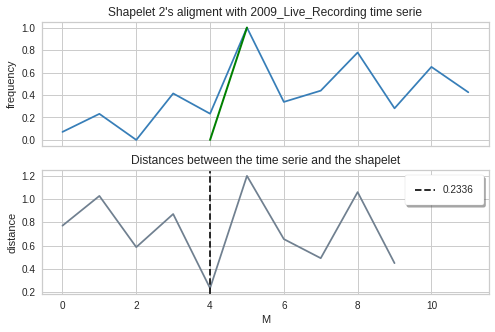

1	test_ts_id=8	pos start=3	pos_end=5
0.4174653007270323 3


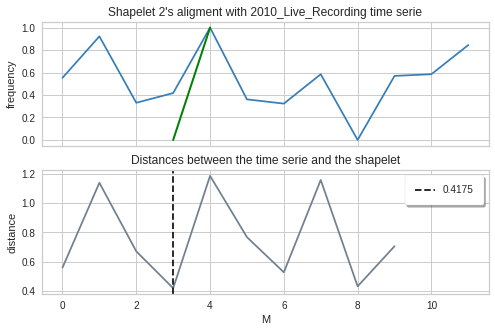

1	test_ts_id=9	pos start=5	pos_end=7
0.23577416310442467 5


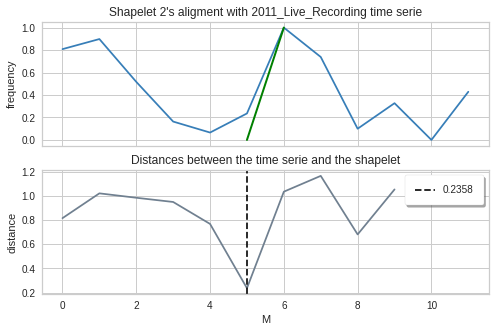

1	test_ts_id=10	pos start=2	pos_end=4
0.22281596234924989 2


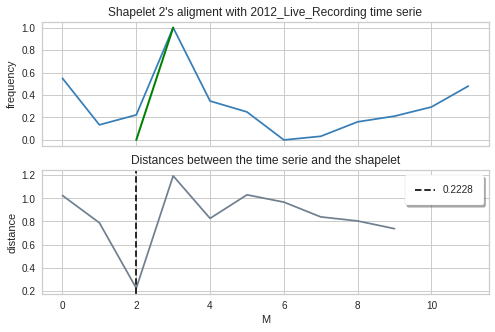

1	test_ts_id=11	pos start=2	pos_end=4
0.2499941315931551 2


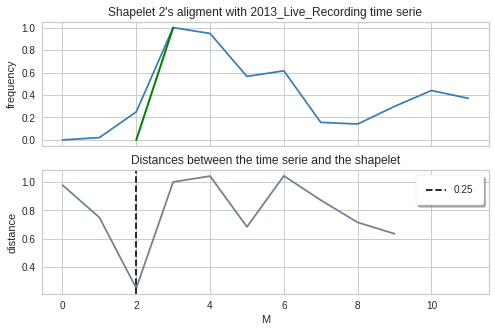

1	test_ts_id=12	pos start=4	pos_end=6
0.3402473589796709 4


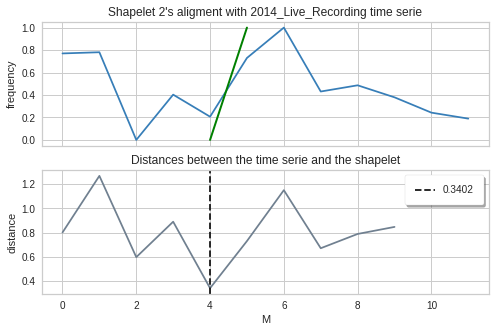

1	test_ts_id=13	pos start=0	pos_end=2
0.16557544012803738 0


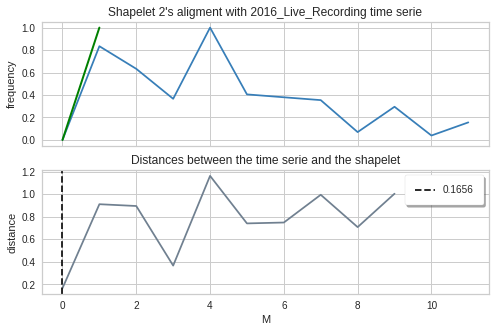


1	{'2015_studio': 0.0, '2014_live': 0.1656, '2011_studio': 0.1715, '2012_studio': 0.1791, '2011_live': 0.2228, '2016_studio': 0.2336, '2010_live': 0.2358, '2012_live': 0.25, '2013_live': 0.3402, '2009_live': 0.4175, '2014_studio': 0.4231, '2013_studio': 0.4407, '2009_studio': 0.4688, '2010_studio': 0.5843}
--------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
0	test_ts_id=0	pos start=3	pos_end=5
0.2718592964824121 3


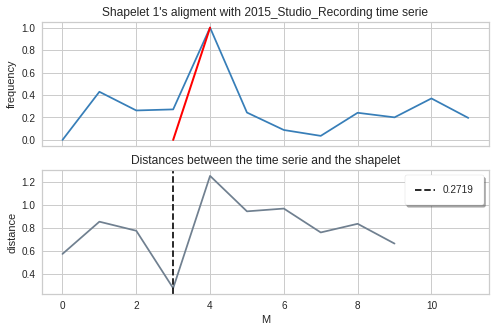

0	test_ts_id=1	pos start=6	pos_end=8
0.25217391304347825 6


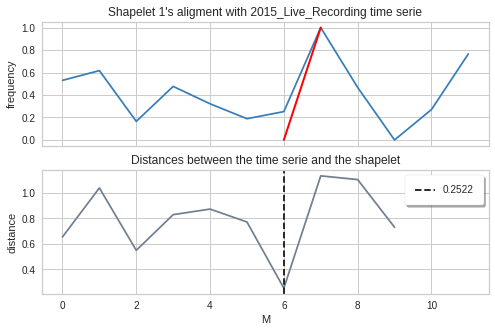


0	{'2010_studio': 0.2522, '2009_studio': 0.2719}
--------------------------------------------------------------------------------------------------

1	test_ts_id=0	pos start=3	pos_end=5
0.2718592964824121 3


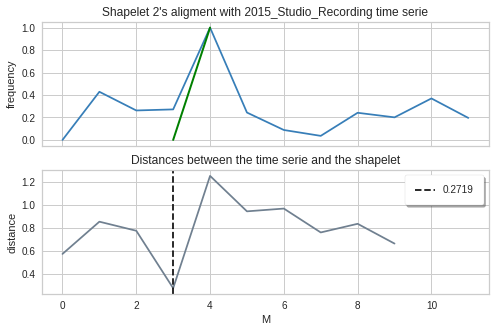

1	test_ts_id=1	pos start=6	pos_end=8
0.25217391304347825 6


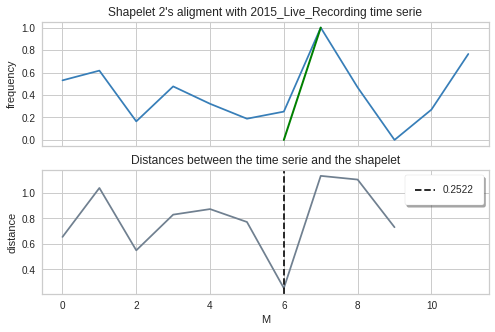


1	{'2010_studio': 0.2522, '2009_studio': 0.2719}
--------------------------------------------------------------------------------------------------



In [55]:
m_shp_clf, m_X_tr, m_X_tr_indeces, m_y_tr, m_y_ts = shaplet_grid_search(g='M', n_shapelets_per_size=-1)

<h6> W </h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/model_se

W Best Config: {'model__weight_regularizer': 0.0001, 'model__total_lengths': 2, 'model__shapelet_length': 0.2} 
y_test [0 1] y_pred [1 1]


/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


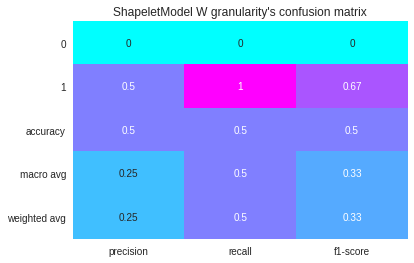

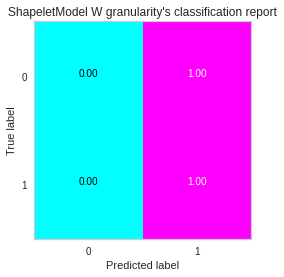

<Figure size 576x360 with 0 Axes>

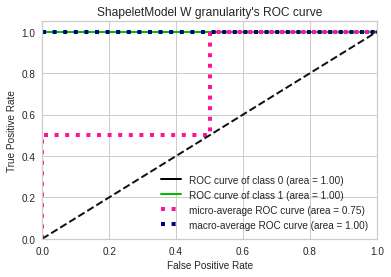

<Figure size 576x360 with 0 Axes>

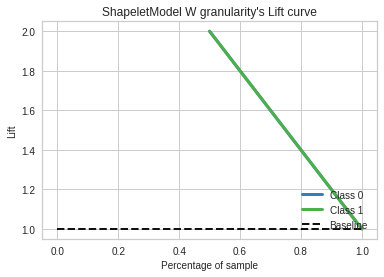

g=W n_ts=14 ts_sz=52 n_classes=2
n_shapelets_per_size {10: 2}


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


0	test_ts_id=0	pos start=4	pos_end=14
1.0142248171884947 4


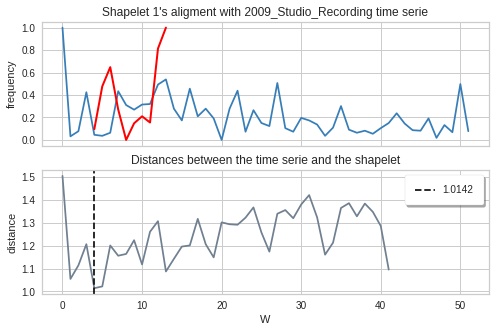

0	test_ts_id=1	pos start=8	pos_end=18
1.0505759701510813 8


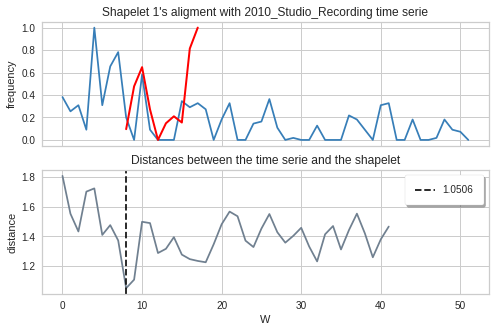

0	test_ts_id=2	pos start=7	pos_end=17
0.7893699919722075 7


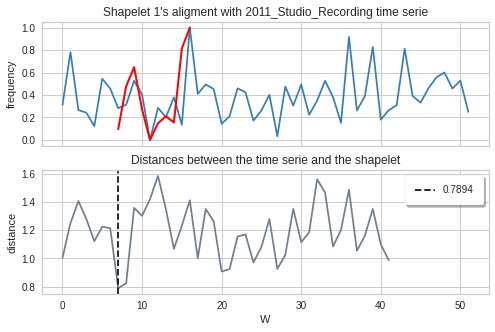

0	test_ts_id=3	pos start=33	pos_end=43
0.8361650660111047 33


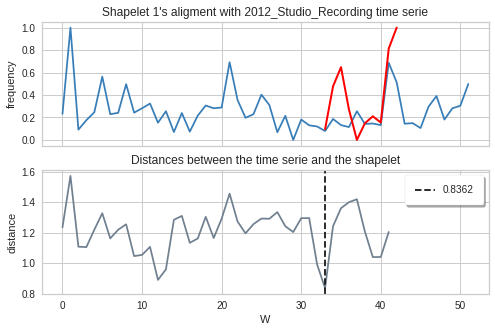

0	test_ts_id=4	pos start=15	pos_end=25
0.9293819453006016 15


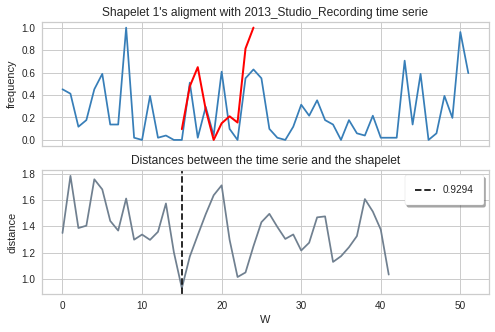

0	test_ts_id=5	pos start=19	pos_end=29
0.8947351566125404 19


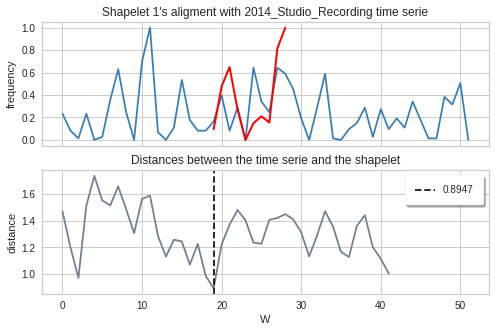

0	test_ts_id=6	pos start=26	pos_end=36
0.7670227913167946 26


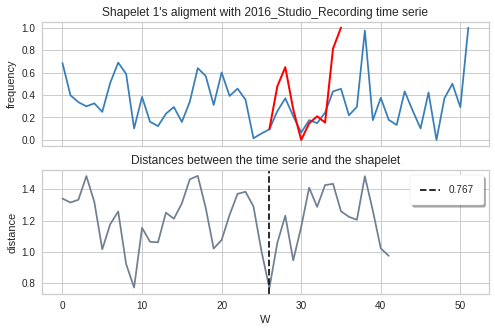

0	test_ts_id=7	pos start=14	pos_end=24
0.6475755418131178 14


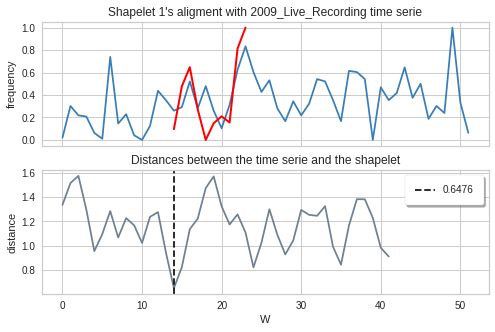

0	test_ts_id=8	pos start=22	pos_end=32
0.7100371765527987 22


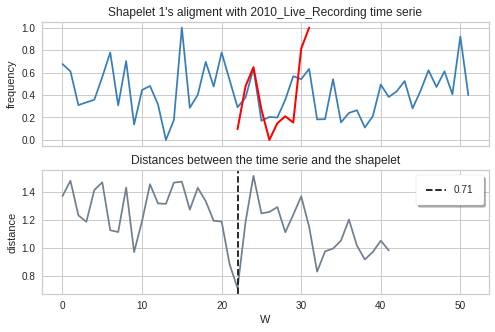

0	test_ts_id=9	pos start=17	pos_end=27
0.9433488667330974 17


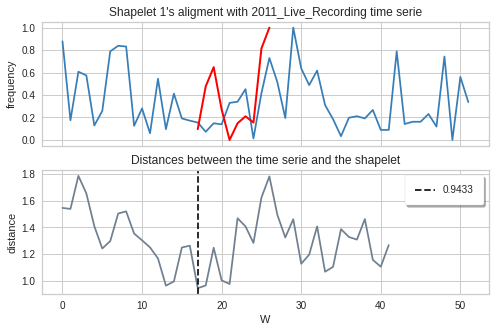

0	test_ts_id=10	pos start=4	pos_end=14
0.9860892705763068 4


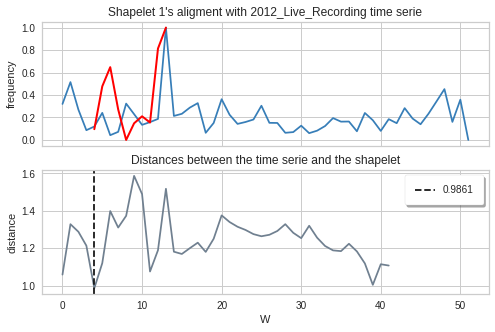

0	test_ts_id=11	pos start=4	pos_end=14
0.8392316749408024 4


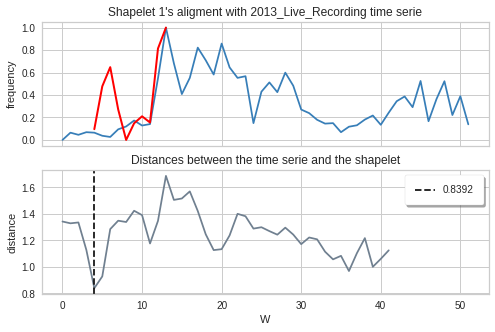

0	test_ts_id=12	pos start=14	pos_end=24
1.0198652306615255 14


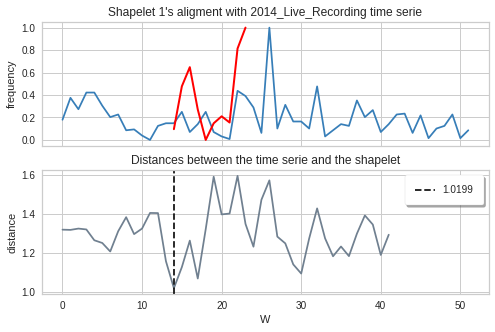

0	test_ts_id=13	pos start=3	pos_end=13
0.9623970354362276 3


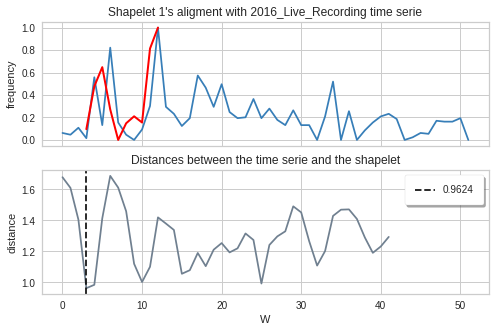


0	{'2016_studio': 0.6476, '2009_live': 0.71, '2015_studio': 0.767, '2011_studio': 0.7894, '2012_studio': 0.8362, '2012_live': 0.8392, '2014_studio': 0.8947, '2013_studio': 0.9294, '2010_live': 0.9433, '2014_live': 0.9624, '2011_live': 0.9861, '2009_studio': 1.0142, '2013_live': 1.0199, '2010_studio': 1.0506}
--------------------------------------------------------------------------------------------------

1	test_ts_id=0	pos start=5	pos_end=15
1.2355628196079373 5


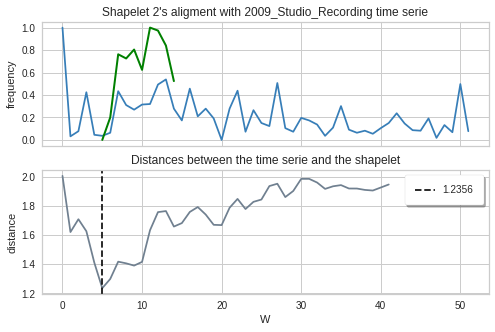

1	test_ts_id=1	pos start=0	pos_end=10
1.3168696575231138 0


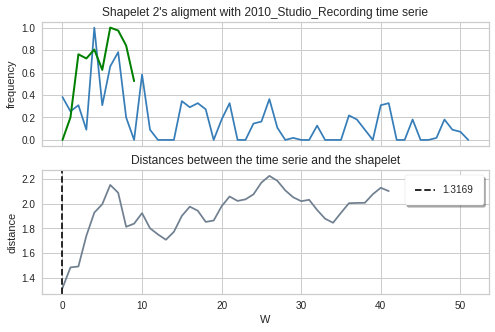

1	test_ts_id=2	pos start=41	pos_end=51
0.9632555080040549 41


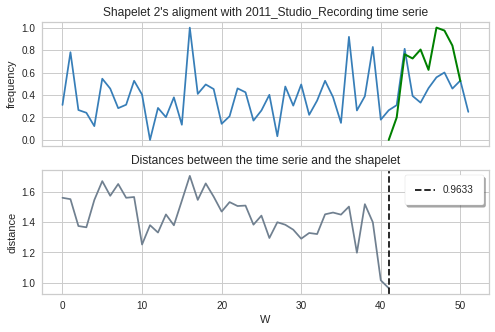

1	test_ts_id=3	pos start=15	pos_end=25
1.381955376018641 15


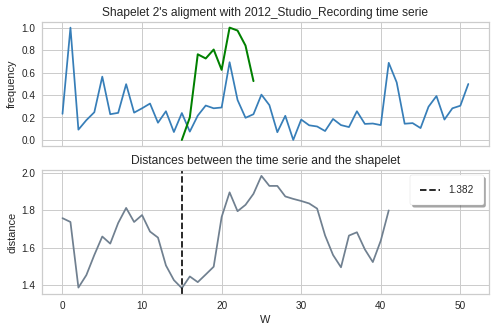

1	test_ts_id=4	pos start=17	pos_end=27
1.42261362288942 17


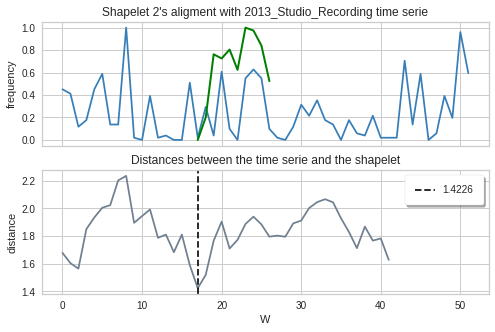

1	test_ts_id=5	pos start=21	pos_end=31
1.2222372122371172 21


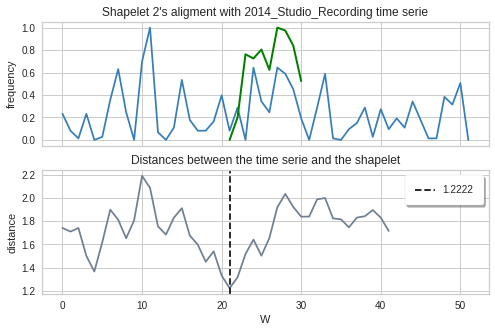

1	test_ts_id=6	pos start=14	pos_end=24
1.0482567330035912 14


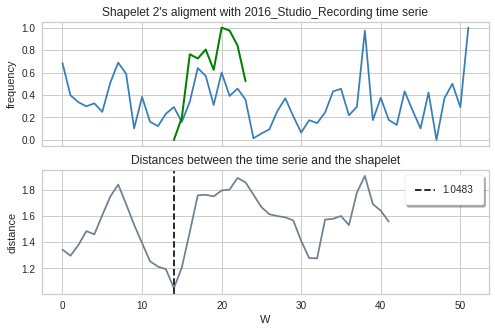

1	test_ts_id=7	pos start=30	pos_end=40
1.101837684587417 30


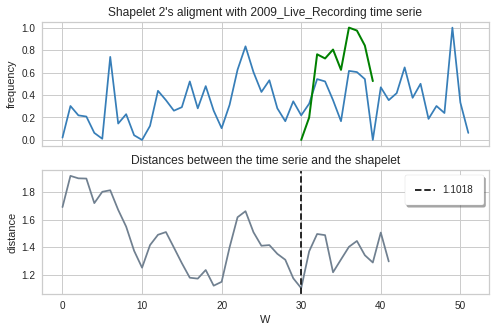

1	test_ts_id=8	pos start=13	pos_end=23
0.9371646859335784 13


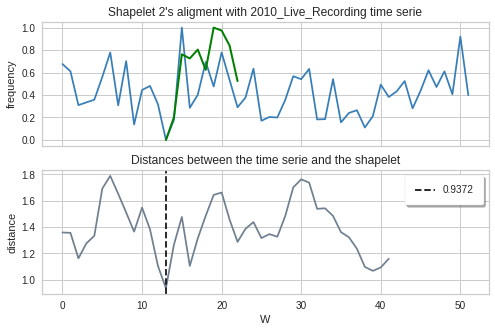

1	test_ts_id=9	pos start=23	pos_end=33
0.9345755921233138 23


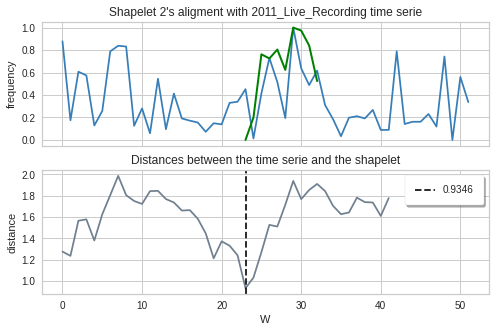

1	test_ts_id=10	pos start=6	pos_end=16
1.5038608939749654 6


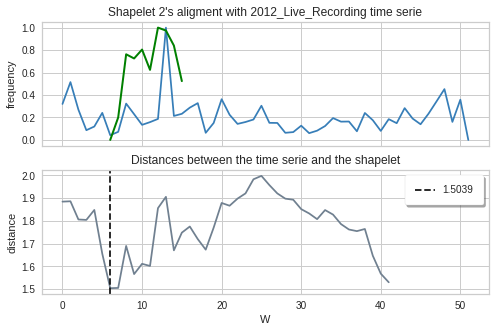

1	test_ts_id=11	pos start=10	pos_end=20
0.6682823351990912 10


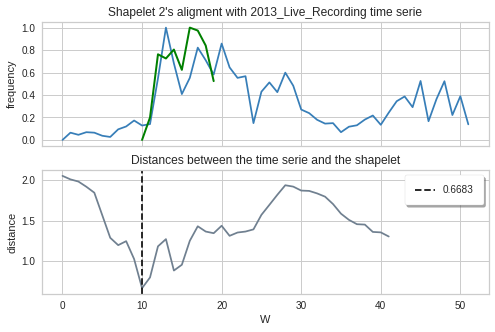

1	test_ts_id=12	pos start=20	pos_end=30
1.4159949555436318 20


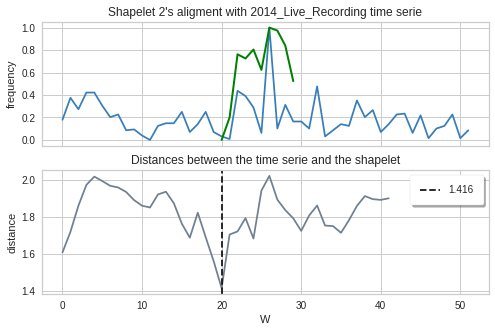

1	test_ts_id=13	pos start=10	pos_end=20
1.3570562269361743 10


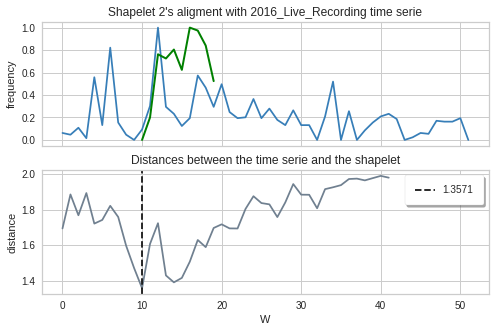


1	{'2012_live': 0.6683, '2010_live': 0.9346, '2009_live': 0.9372, '2011_studio': 0.9633, '2015_studio': 1.0483, '2016_studio': 1.1018, '2014_studio': 1.2222, '2009_studio': 1.2356, '2010_studio': 1.3169, '2014_live': 1.3571, '2012_studio': 1.382, '2013_live': 1.416, '2013_studio': 1.4226, '2011_live': 1.5039}
--------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
0	test_ts_id=0	pos start=11	pos_end=21
0.8584116559571362 11


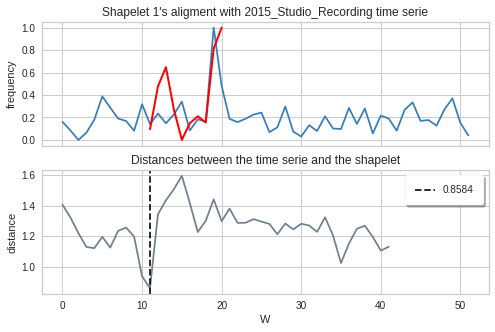

0	test_ts_id=1	pos start=25	pos_end=35
0.9502363663552712 25


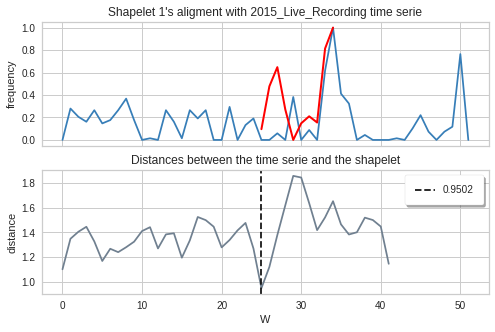


0	{'2009_studio': 0.8584, '2010_studio': 0.9502}
--------------------------------------------------------------------------------------------------

1	test_ts_id=0	pos start=13	pos_end=23
1.418617394367624 13


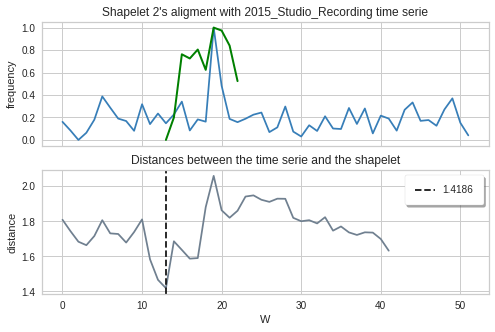

1	test_ts_id=1	pos start=27	pos_end=37
1.4096086062082682 27


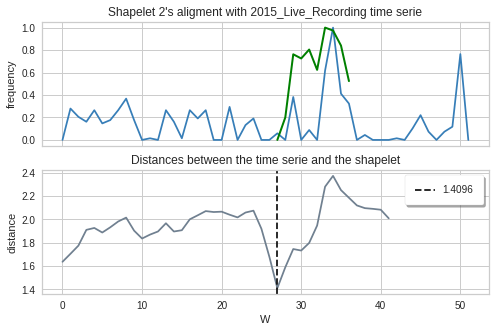


1	{'2010_studio': 1.4096, '2009_studio': 1.4186}
--------------------------------------------------------------------------------------------------



In [56]:
w_shp_clf, w_X_tr, w_X_tr_indeces, w_y_tr, w_y_ts = shaplet_grid_search(g='W', n_shapelets_per_size=-1)

<h6> D </h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/model_se

D Best Config: {'model__weight_regularizer': 0.0001, 'model__total_lengths': 2, 'model__shapelet_length': 0.2} 
y_test [0 1] y_pred [0 1]


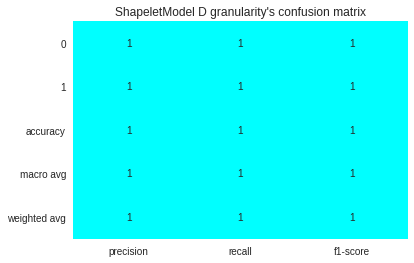

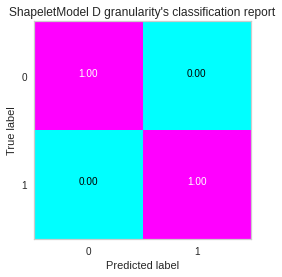

<Figure size 576x360 with 0 Axes>

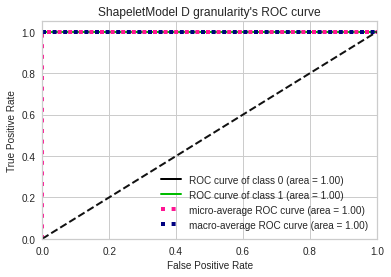

<Figure size 576x360 with 0 Axes>

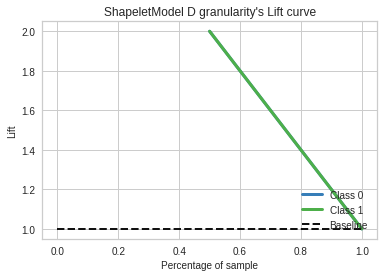

g=D n_ts=14 ts_sz=365 n_classes=2
n_shapelets_per_size {73: 2}


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


0	test_ts_id=0	pos start=49	pos_end=122
4.360433057929146 49


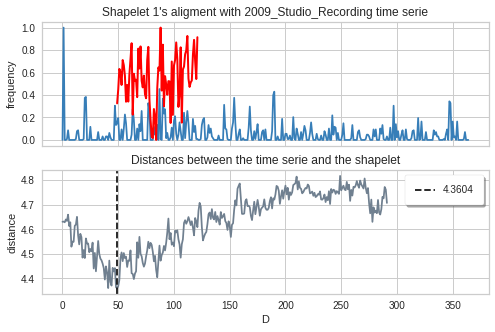

0	test_ts_id=1	pos start=9	pos_end=82
4.647796977629426 9


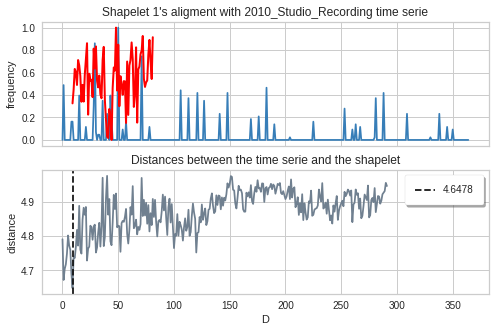

0	test_ts_id=2	pos start=287	pos_end=360
3.7041342950858276 287


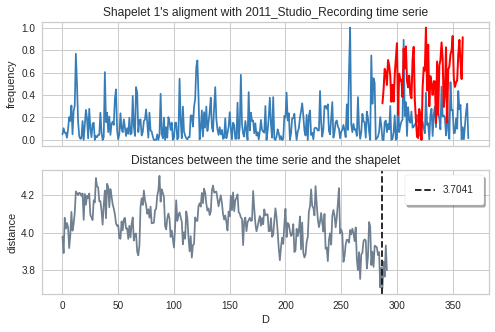

0	test_ts_id=3	pos start=20	pos_end=93
4.133896937210164 20


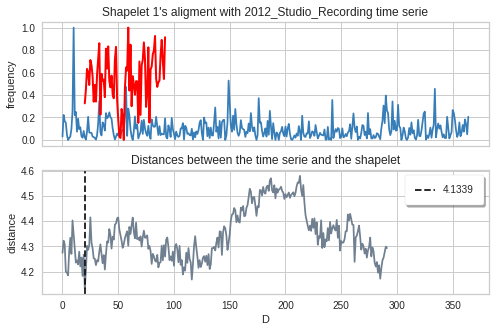

0	test_ts_id=4	pos start=20	pos_end=93
4.459939419871886 20


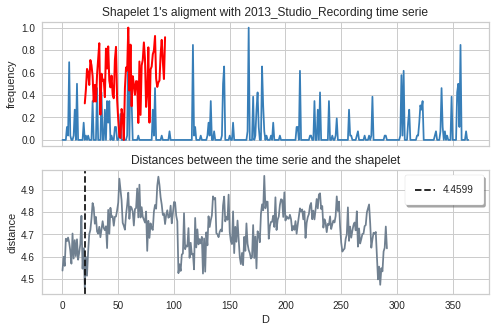

0	test_ts_id=5	pos start=129	pos_end=202
4.497475422753878 129


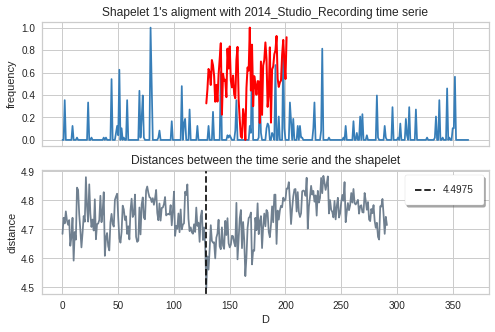

0	test_ts_id=6	pos start=6	pos_end=79
3.8341168385202127 6


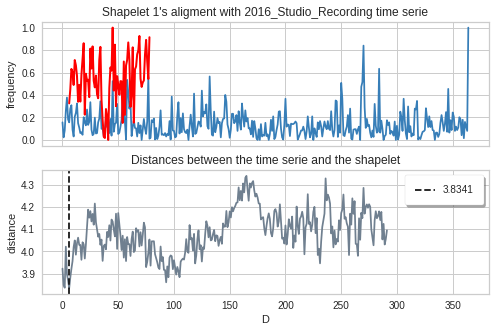

0	test_ts_id=7	pos start=116	pos_end=189
4.086002187541443 116


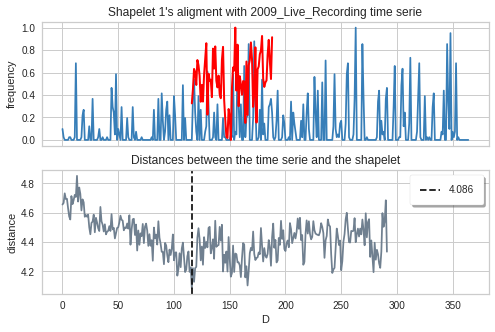

0	test_ts_id=8	pos start=282	pos_end=355
3.957537534548148 282


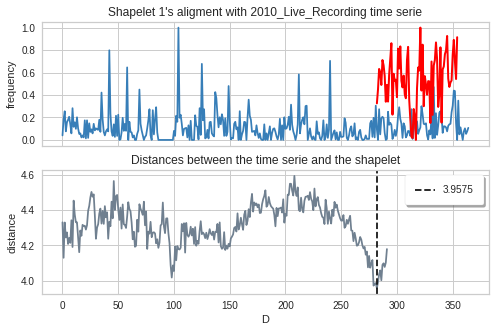

0	test_ts_id=9	pos start=0	pos_end=73
3.5206573511311947 0


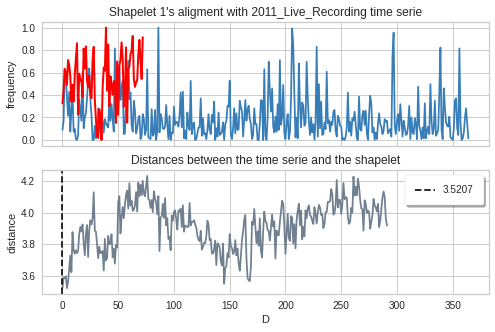

0	test_ts_id=10	pos start=54	pos_end=127
4.07245288753204 54


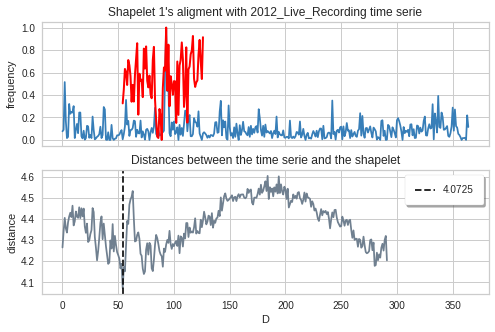

0	test_ts_id=11	pos start=83	pos_end=156
3.672810822787903 83


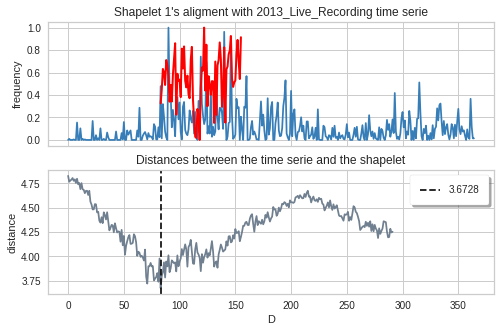

0	test_ts_id=12	pos start=159	pos_end=232
4.472650079005703 159


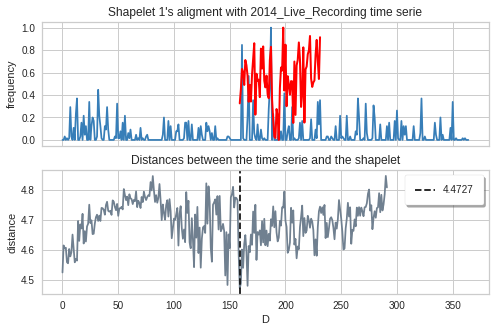

0	test_ts_id=13	pos start=76	pos_end=149
4.441907553931206 76


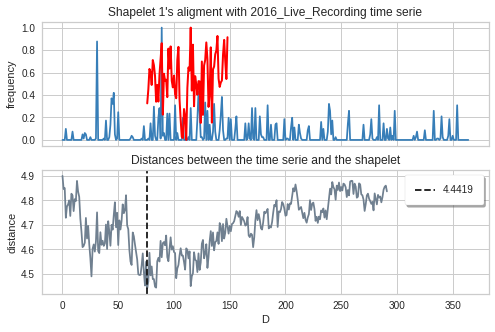


0	{'2010_live': 3.5207, '2012_live': 3.6728, '2011_studio': 3.7041, '2015_studio': 3.8341, '2009_live': 3.9575, '2011_live': 4.0725, '2016_studio': 4.086, '2012_studio': 4.1339, '2009_studio': 4.3604, '2014_live': 4.4419, '2013_studio': 4.4599, '2013_live': 4.4727, '2014_studio': 4.4975, '2010_studio': 4.6478}
--------------------------------------------------------------------------------------------------

1	test_ts_id=0	pos start=48	pos_end=121
4.291864937732608 48


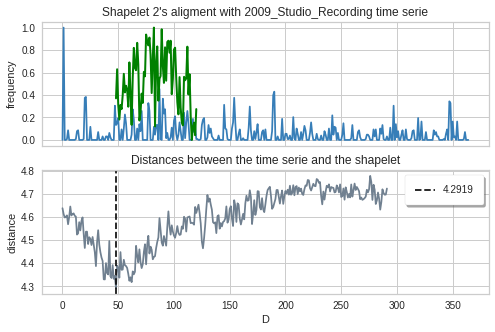

1	test_ts_id=1	pos start=9	pos_end=82
4.4992477558987884 9


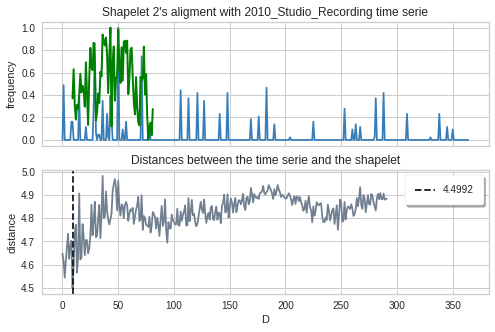

1	test_ts_id=2	pos start=289	pos_end=362
3.7381471699818927 289


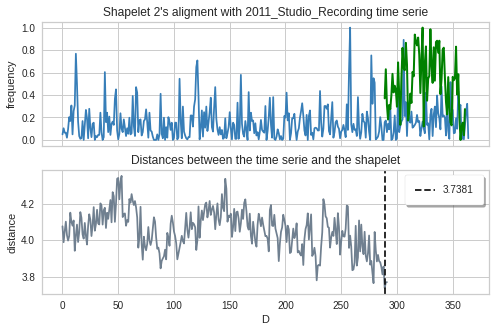

1	test_ts_id=3	pos start=122	pos_end=195
4.10267429220236 122


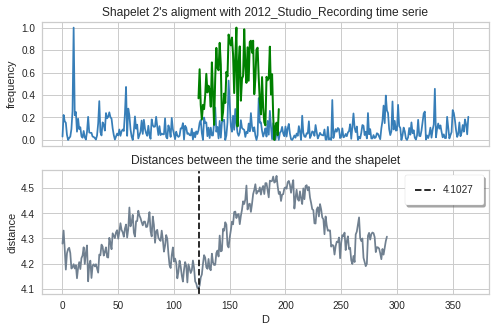

1	test_ts_id=4	pos start=126	pos_end=199
4.3801206045831655 126


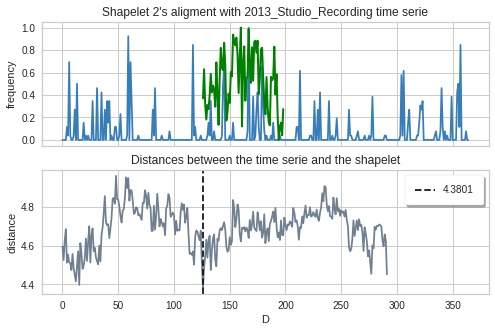

1	test_ts_id=5	pos start=150	pos_end=223
4.432495518207139 150


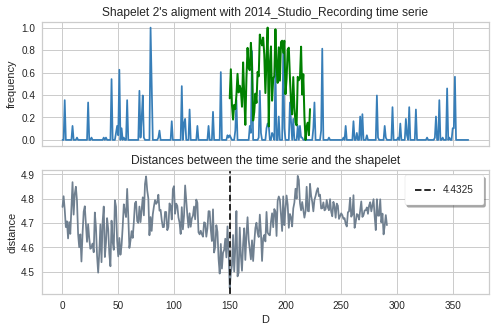

1	test_ts_id=6	pos start=99	pos_end=172
3.6857362052513705 99


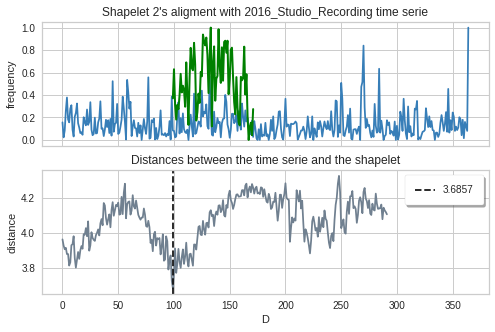

1	test_ts_id=7	pos start=138	pos_end=211
4.039766899342359 138


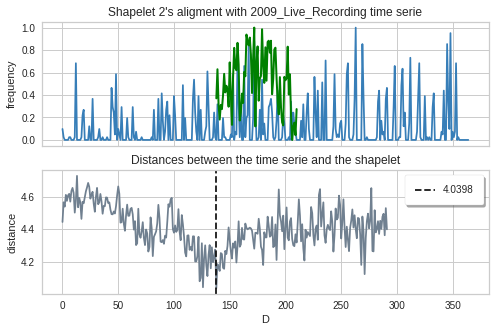

1	test_ts_id=8	pos start=286	pos_end=359
3.9485298542944953 286


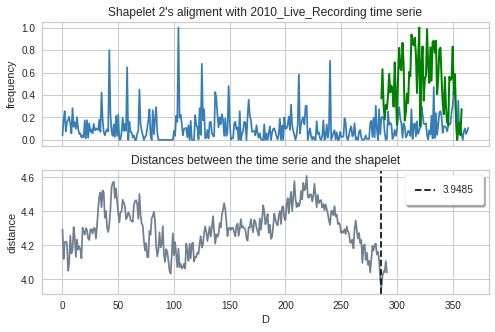

1	test_ts_id=9	pos start=179	pos_end=252
3.3943857778092044 179


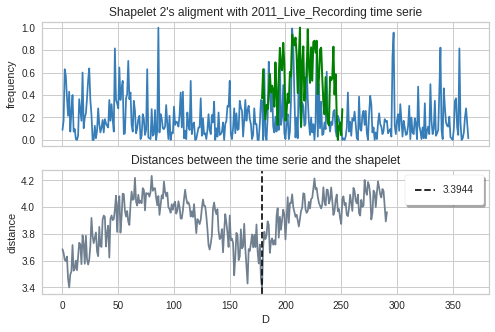

1	test_ts_id=10	pos start=65	pos_end=138
4.0229247332406075 65


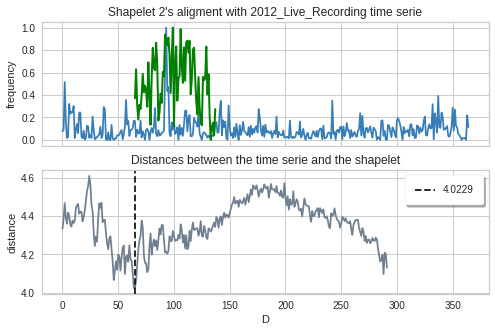

1	test_ts_id=11	pos start=94	pos_end=167
3.5606698931160476 94


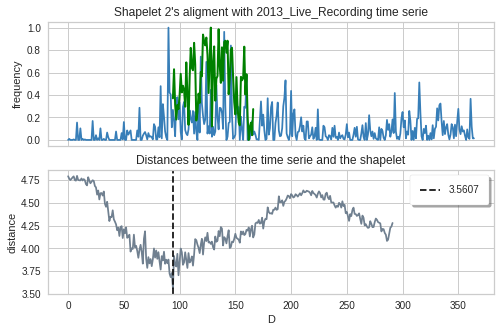

1	test_ts_id=12	pos start=160	pos_end=233
4.454362032406781 160


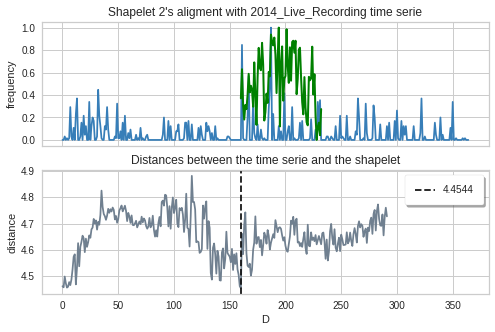

1	test_ts_id=13	pos start=103	pos_end=176
4.409625407003299 103


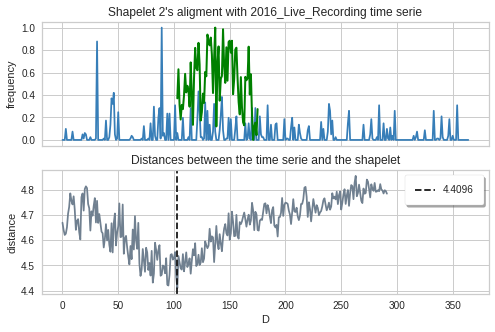


1	{'2010_live': 3.3944, '2012_live': 3.5607, '2015_studio': 3.6857, '2011_studio': 3.7381, '2009_live': 3.9485, '2011_live': 4.0229, '2016_studio': 4.0398, '2012_studio': 4.1027, '2009_studio': 4.2919, '2013_studio': 4.3801, '2014_live': 4.4096, '2014_studio': 4.4325, '2013_live': 4.4544, '2010_studio': 4.4992}
--------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
0	test_ts_id=0	pos start=68	pos_end=141
4.115437202870619 68


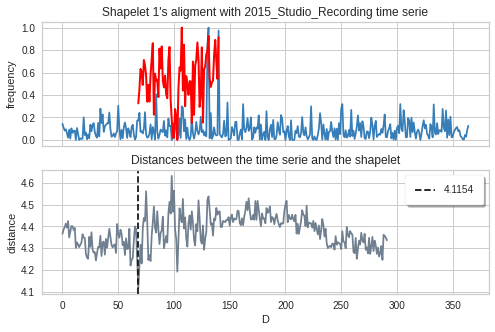

0	test_ts_id=1	pos start=192	pos_end=265
4.660624665001039 192


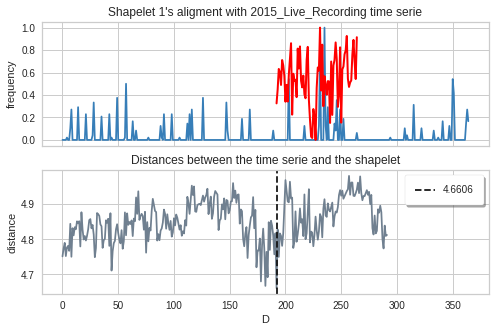


0	{'2009_studio': 4.1154, '2010_studio': 4.6606}
--------------------------------------------------------------------------------------------------

1	test_ts_id=0	pos start=103	pos_end=176
4.170337474340443 103


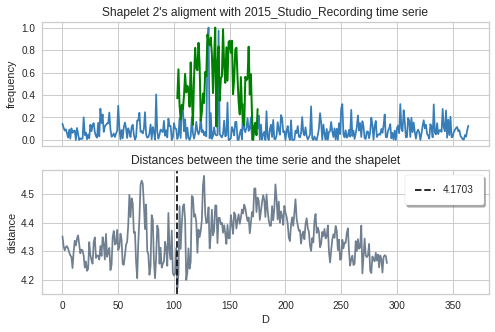

1	test_ts_id=1	pos start=201	pos_end=274
4.5683976907603006 201


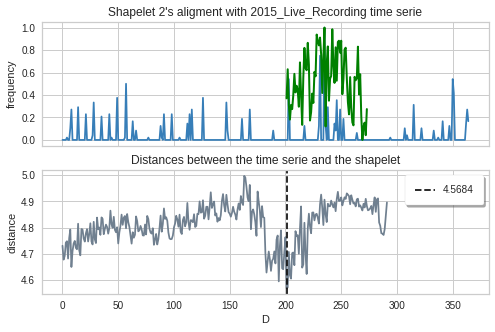


1	{'2009_studio': 4.1703, '2010_studio': 4.5684}
--------------------------------------------------------------------------------------------------



In [98]:
d_shp_clf, d_X_tr, d_X_tr_indeces, d_y_tr, d_y_ts = shaplet_grid_search(g='D', n_shapelets_per_size=-1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/model_se

D Best Config: {'model__weight_regularizer': 0.0001, 'model__total_lengths': 2, 'model__shapelet_length': 0.2} 
y_test [0 1] y_pred [0 1]


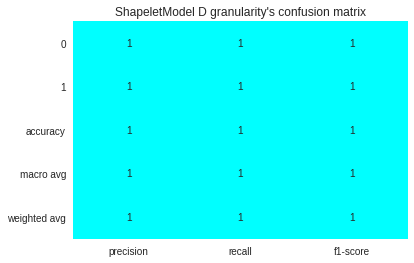

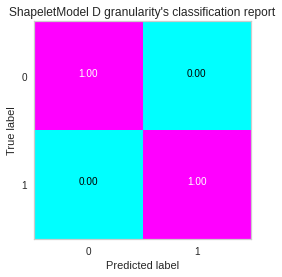

<Figure size 576x360 with 0 Axes>

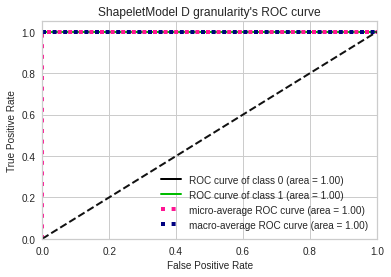

<Figure size 576x360 with 0 Axes>

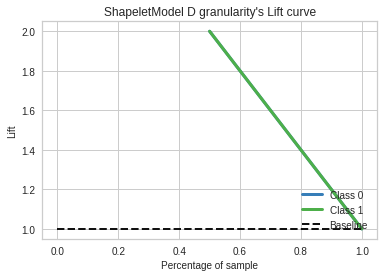

g=D n_ts=14 ts_sz=365 n_classes=2
n_shapelets_per_size {73: 2}


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


0	test_ts_id=0	pos start=209	pos_end=282
5.011824494112407 209


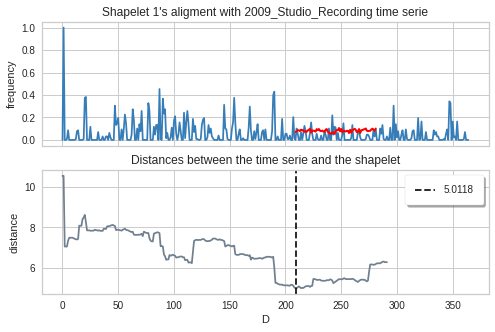

0	test_ts_id=1	pos start=195	pos_end=268
6.1210963010295 195


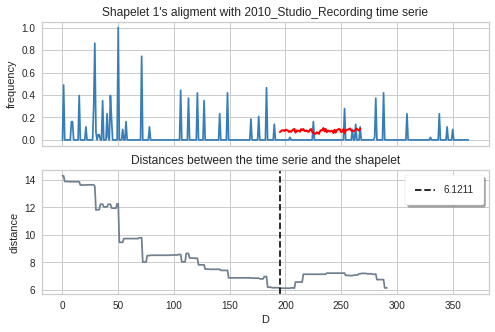

0	test_ts_id=2	pos start=162	pos_end=235
8.887496220486737 162


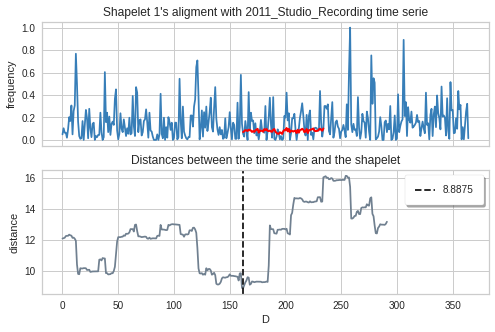

0	test_ts_id=3	pos start=64	pos_end=137
4.272992266018382 64


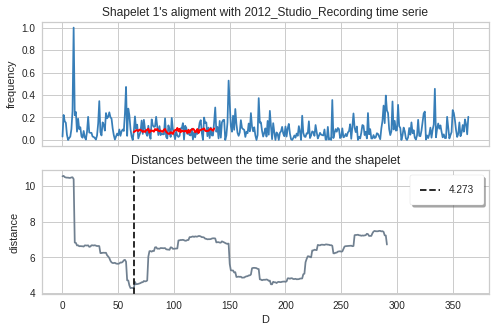

0	test_ts_id=4	pos start=231	pos_end=304
7.309683607895507 231


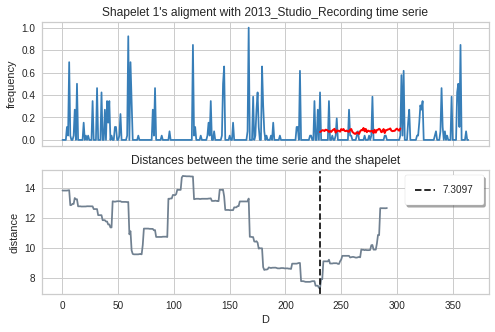

0	test_ts_id=5	pos start=237	pos_end=310
6.69838114511679 237


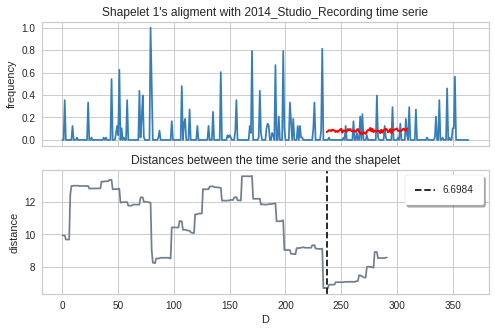

0	test_ts_id=6	pos start=168	pos_end=241
5.406137554313789 168


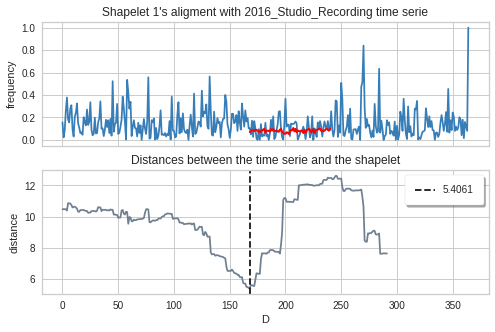

0	test_ts_id=7	pos start=13	pos_end=86
8.975809350082093 13


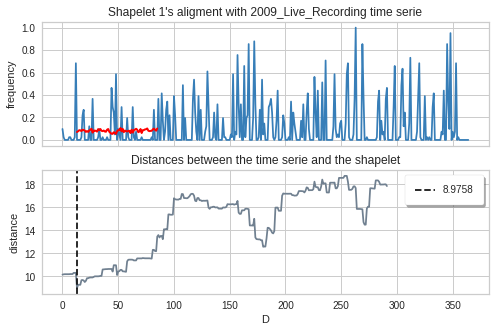

0	test_ts_id=8	pos start=249	pos_end=322
6.026827836814545 249


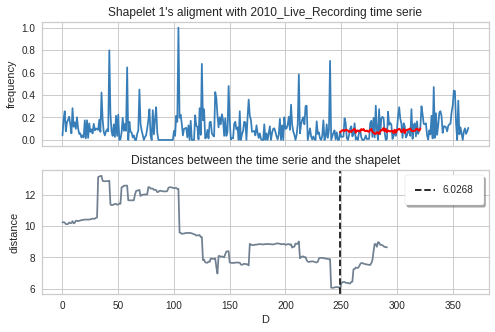

0	test_ts_id=9	pos start=87	pos_end=160
10.213297022083491 87


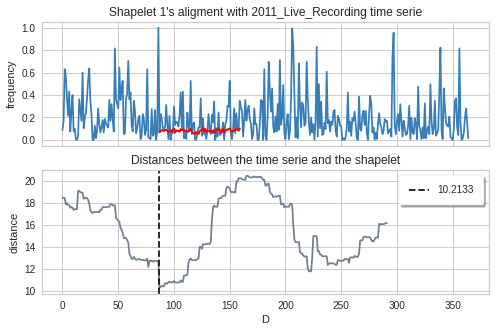

0	test_ts_id=10	pos start=160	pos_end=233
3.9255680955153096 160


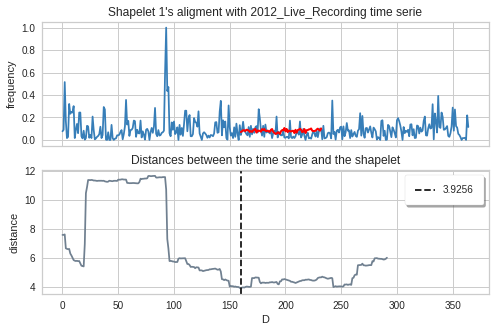

0	test_ts_id=11	pos start=218	pos_end=291
4.792545305385489 218


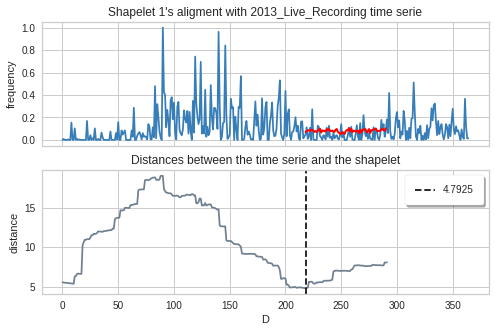

0	test_ts_id=12	pos start=65	pos_end=138
5.401607265139839 65


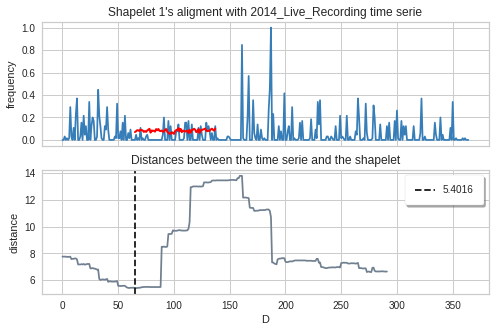

0	test_ts_id=13	pos start=258	pos_end=331
6.137786564928559 258


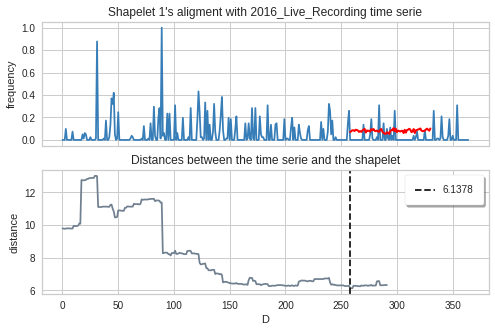


0	{'2011_live': 3.9256, '2012_studio': 4.273, '2012_live': 4.7925, '2009_studio': 5.0118, '2013_live': 5.4016, '2015_studio': 5.4061, '2009_live': 6.0268, '2010_studio': 6.1211, '2014_live': 6.1378, '2014_studio': 6.6984, '2013_studio': 7.3097, '2011_studio': 8.8875, '2016_studio': 8.9758, '2010_live': 10.2133}
--------------------------------------------------------------------------------------------------

1	test_ts_id=0	pos start=91	pos_end=164
8.867272122546874 91


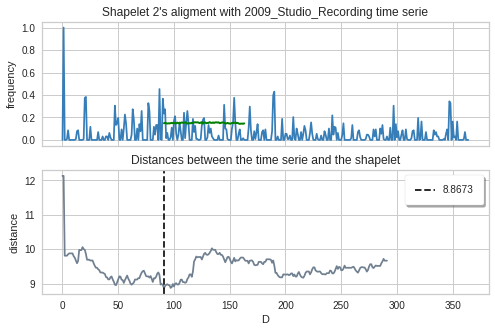

1	test_ts_id=1	pos start=195	pos_end=268
10.693177665623097 195


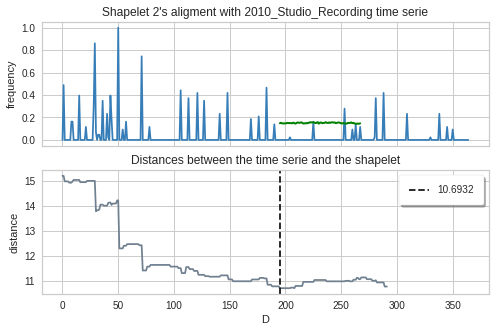

1	test_ts_id=2	pos start=169	pos_end=242
8.270557580838659 169


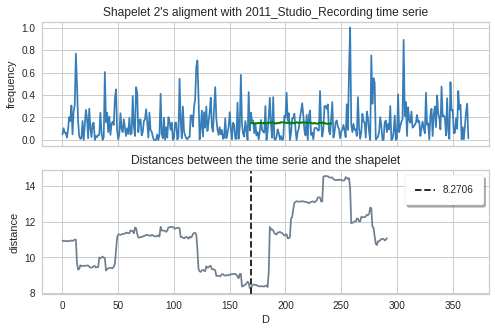

1	test_ts_id=3	pos start=64	pos_end=137
6.323955733897847 64


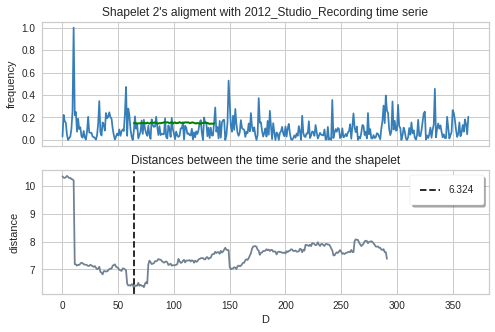

1	test_ts_id=4	pos start=218	pos_end=291
10.81240173873189 218


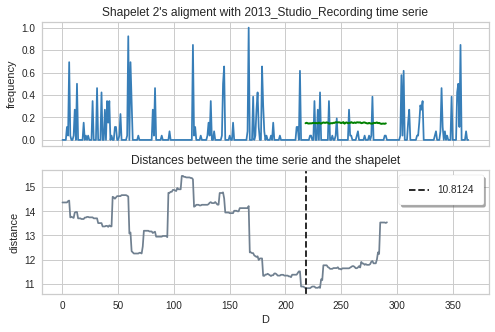

1	test_ts_id=5	pos start=246	pos_end=319
10.397476762282151 246


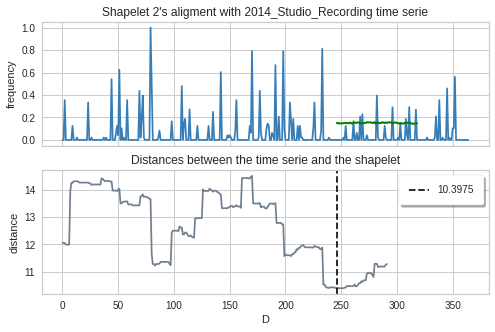

1	test_ts_id=6	pos start=165	pos_end=238
6.444638890674473 165


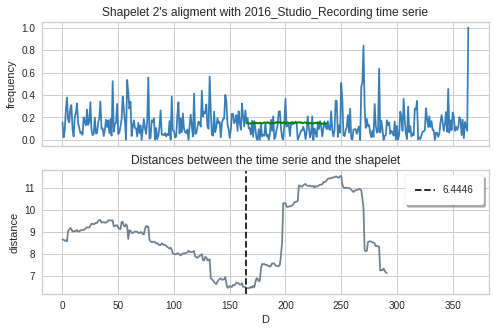

1	test_ts_id=7	pos start=13	pos_end=86
11.116292063572532 13


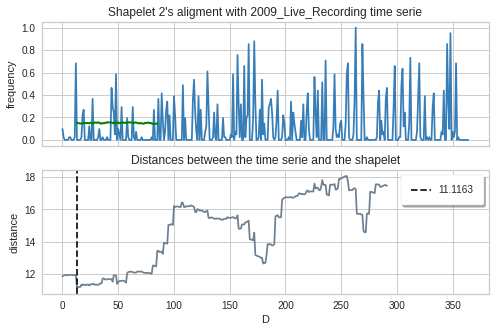

1	test_ts_id=8	pos start=276	pos_end=349
7.017749910948907 276


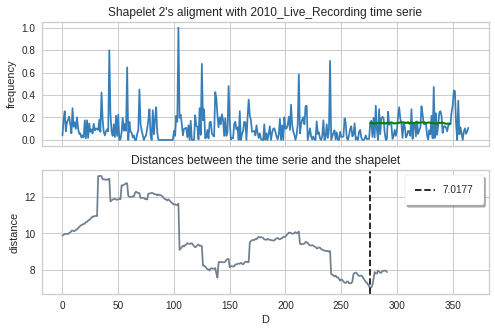

1	test_ts_id=9	pos start=87	pos_end=160
9.026415569307598 87


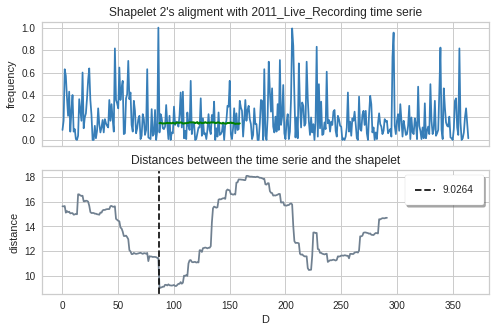

1	test_ts_id=10	pos start=259	pos_end=332
6.318818188481725 259


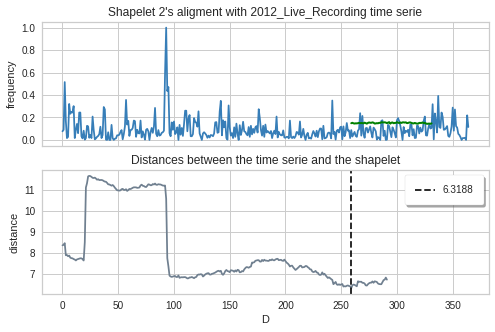

1	test_ts_id=11	pos start=286	pos_end=359
7.938558784608606 286


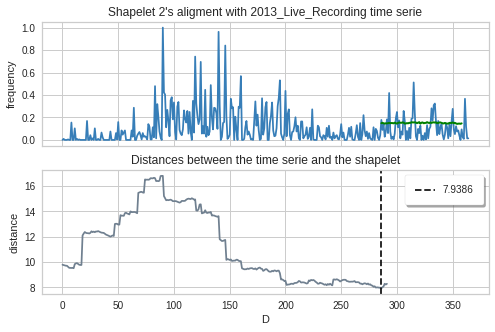

1	test_ts_id=12	pos start=65	pos_end=138
9.374294433929517 65


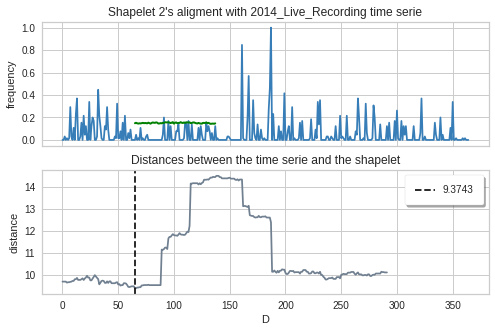

1	test_ts_id=13	pos start=149	pos_end=222
9.485301704317054 149


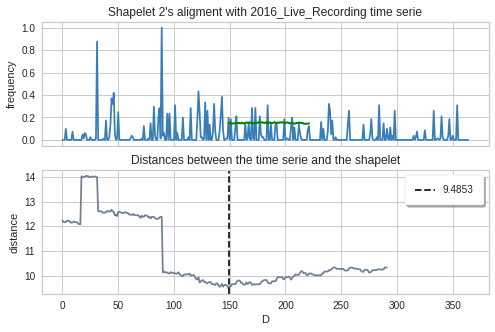


1	{'2011_live': 6.3188, '2012_studio': 6.324, '2015_studio': 6.4446, '2009_live': 7.0177, '2012_live': 7.9386, '2011_studio': 8.2706, '2009_studio': 8.8673, '2010_live': 9.0264, '2013_live': 9.3743, '2014_live': 9.4853, '2014_studio': 10.3975, '2010_studio': 10.6932, '2013_studio': 10.8124, '2016_studio': 11.1163}
--------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
0	test_ts_id=0	pos start=1	pos_end=74
5.042865755002537 1


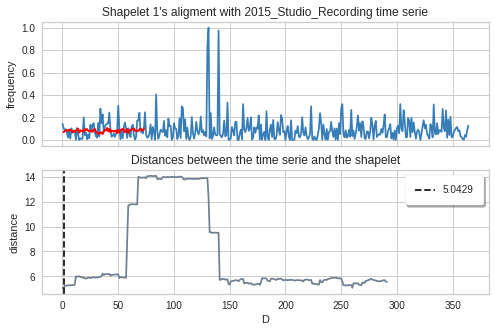

0	test_ts_id=1	pos start=275	pos_end=348
6.113242055908335 275


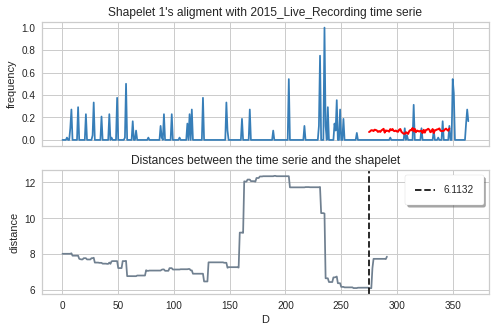


0	{'2009_studio': 5.0429, '2010_studio': 6.1132}
--------------------------------------------------------------------------------------------------

1	test_ts_id=0	pos start=284	pos_end=357
6.641660233994866 284


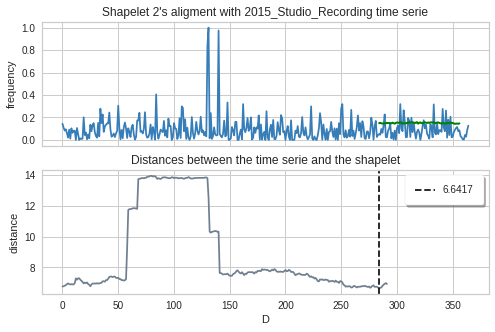

1	test_ts_id=1	pos start=59	pos_end=132
10.57253514917409 59


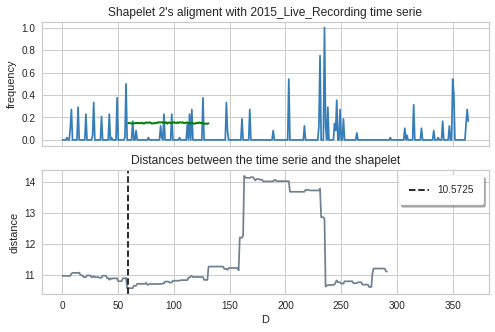


1	{'2009_studio': 6.6417, '2010_studio': 10.5725}
--------------------------------------------------------------------------------------------------



In [67]:
d_shp_clf2, d_X_tr2, d_X_tr_indeces2, d_y_tr2, d_y_ts2 = shaplet_grid_search(g='D', n_shapelets_per_size=-1)

<h6> H </h6>

In [63]:
# h_shp_clf, h_X_tr, h_X_tr_indeces, h_y_tr, h_y_ts = shaplet_grid_search(g='H', n_shapelets_per_size=-1)